### Notebook 2: Synthetic Models - Listric Faults
-extracting exhumation information from more complex fault geometries \\
-inversion using a different number and distribution of data points

In [1]:
import pynoddy
import importlib
importlib.reload(pynoddy)
import pynoddy.history
import pandas as pd
import pickle
import copy
from tqdm import tqdm
import numpy as np
import pynoddy.output
import sys, os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath('../hspace'))
import hspace.measures
importlib.reload(hspace.measures)

sys.path.append(os.path.abspath('../functions'))
from exh_functions import *
from exh_processing import *

pymc is not installed - Bayesian entropy estimation will not work.
pymc is not installed - Bayesian entropy estimation will not work.
pymc is not installed - Bayesian entropy estimation will not work.


In [2]:
folder = "SyntheticModels"
output_folder = f"outputs/{folder}"
os.makedirs(output_folder, exist_ok=True)

In [3]:
#Note: for computing the noddy models, make sure that you have the noddy executable downloaded - you can find this on pynoddy's
#github page, all you need to do is clone the repository and set the path. Does not work on Mac.
noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe'

### Listric faults model

In [16]:
model = 'listric_faults'
experiment = 1
#For the listric fault model, we carry out three different inversion experiments: 
#Experiment 1: 3 thermochron samples with high (realistic) uncertainty --> load "listric_3samples.his"
#Experiment 2: 3 thermochron samples with low (ideal) uncertainty --> same as above
#Experiment 3: 45 thermochron samples with low (ideal) uncertainty --> load "listric_50samples_1fault.his"

In [17]:
#Load the Noddy models
if experiment in [1,2]:
    history ='../models/listric_3samples.his'
else:
    history ='../models/listric_50samples_1fault.his'
output_name = f'{output_folder}/{model}_out'
pynoddy.compute_model(history, output_name, 
                      noddy_path = noddy_path)

hist = pynoddy.history.NoddyHistory(history)
out_hd = pynoddy.output.NoddyOutput(output_name)

#make it hd
hist.change_cube_size(100)
hist_hd = f'{output_folder}/{model}_hd.his'
out_hd = f'{output_folder}/{model}_out_hd'
hist.write_history(hist_hd)
pynoddy.compute_model(hist_hd, out_hd, noddy_path = noddy_path)
out_hd = pynoddy.output.NoddyOutput(out_hd)

outputs/SyntheticModels/listric_faults_out
outputs/SyntheticModels/listric_faults_out_hd


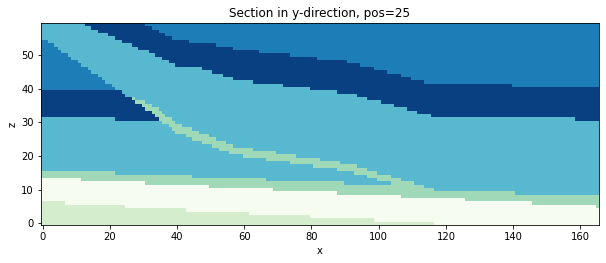

In [18]:
out_hd.plot_section('y', cmap = 'GnBu')

In [19]:
print("Model dimensions (voxels):",out_hd.nx, out_hd.ny, out_hd.nz)
print("Model dimensions (meters):",out_hd.extent_x, out_hd.extent_y, out_hd.extent_z)

Model dimensions (voxels): 166 50 60
Model dimensions (meters): 16600.0 5000.0 6000.0


### Define modeling parameters & load samples

In [22]:
if experiment in [1,2]: #for experiments with 3 samples
    lith_list = [7,8,9] #lith ids of the all sample points
    event_list = [11] #fault ids of faults to modify
    
    #create synthetic AFT data for 2-D example
    samples = pd.read_csv('../data/listric_samples.csv')
    samples = pd.DataFrame(columns = ['sample_id', 'type'])
    samples['sample_id'] = ['sample1', 'sample2', 'sample3']
    samples['type'] = ['a', 'b', 'c']
    samples
else:    #for experiment with 45 samples
    lith_list = np.arange(7,52) #lith ids of the all sample points
    event_list = [53] #fault ids of faults to modify
    
    #load samples
    samples = pd.read_csv('../data/listric_45samples.csv')

conv_factor = ((-1000/1812.63) + (-2000/2675.79))/-2 #raw noddy coordinates * conv_factor = coords in meters. Changes with cubesize
param_list = ['Slip','Z'] #parameters to modify
std_list = [800,600] #std of the parameters

### Before MCMC, define important functions

In [25]:
# important functions 

#calculate the exhumation from the noddy model output
def calc_exhumation(history, lith_list, samples, conv_factor):
    new_hist = f'{output_folder}/{model}_new_hist.his'
    new_out = f'{output_folder}/{model}_new_out'
    
    hist_copy = copy.deepcopy(history)
    
    og_depths = [] #calculate the original depth before exhumation for each sample (they are plugs in noddy)
    for event_name, evento in history.events.items():
        if isinstance(evento, pynoddy.events.Plug):
            z = evento.properties['Z']  
            og_depths.append(z)
   
    new_params = [] #get new random parameters
    for i, event in enumerate(hist_copy.events.values()):
        if isinstance(event, pynoddy.events.Fault):
            new_z = disturb_value(event,'Z',600)
            #new_amp = disturb_value(event,'Amplitude',500)
            new_slip = disturb_value(event,'Slip',800)
            #new_dip = disturb_value(event, 'Dip', 15)
            new_params.append((i, new_slip, new_z))
    hist_copy.write_history(new_hist) #recompute the model - we need to do this to be able to extract coordinates
    pynoddy.compute_model(new_hist, new_out, noddy_path = noddy_path)
    out = pynoddy.output.NoddyOutput(new_out)
    
    try:
        exhumation = calc_new_position(out, og_depths, lith_list, samples, conv_factor) #calculate the exhumation with new params
    #sometimes there is an IndexError when the coordinates are not found - it is not often though. 
    #it happens randomly, either due to the resolution (cannot detect the coords) or the sample is outside the model extent.
    except IndexError: 
        samples['exhumation'] = 9999
        exhumation = samples
    
    return exhumation, new_params, hist_copy, out

def calc_new_position(output, og_depths, lith_list,samples, conv_factor):
    samples_noddy_pos = []
    
    for i in lith_list:
        p = ExtractCoordsSimple(output, lith = [i], res = 2) #extract the coordinates of the samples from noddy 
        t = p[...,2].max() * conv_factor #perform conversion from noddy coordinates -> meters
        samples_noddy_pos.append(t)
    if len(lith_list) > 1:
        proposed_exhumation = [x - z for x,z in zip(samples_noddy_pos, og_depths)] #calculate the exhumation as the diff between the original depth and the current depth
    samples['exhumation'] = proposed_exhumation
    return samples


# MCMC functions
def create_pdf(mean, std_dev):
    def pdf(x):
        coeff = 1 / (std_dev * np.sqrt(2 * np.pi))
        exponent = - ((x - mean) ** 2) / (2 * std_dev ** 2)
        return coeff * np.exp(exponent)
    return pdf

def prior_dist(og_params,proposed_params,std_list):
    log_prior_prob = 1.0
    for i in range(len(og_params)):
        for j in range(len(std_list)):
            pdf = create_pdf(og_params[i][j+1], std_list[j])
            prior_prob *= pdf(proposed_params[i][j+1])
    return prior_prob

def likelihood_generic(exhumation): #input = sample dataframe with expected exh ranges.
    likelihood = 1.0
    
    for i in range(len(exhumation)):
        
        if exhumation.iloc[i]['exhumation'] > exhumation.iloc[i]['min'] and exhumation.iloc[i]['exhumation'] < exhumation.iloc[i]['max']:
            likelihood *= 1
            
        elif exhumation.iloc[i]['exhumation'] < exhumation.iloc[i]['min']:
            proximity = (exhumation.iloc[i]['min'] - exhumation.iloc[i]['exhumation'])/exhumation.iloc[i]['min']
            rf = np.exp(-50*proximity)
            likelihood *= rf
            
        elif exhumation.iloc[i]['exhumation'] > exhumation.iloc[i]['max']:
            proximity = (exhumation.iloc[i]['exhumation'] - exhumation.iloc[i]['min'])/exhumation.iloc[i]['max']
            rf = np.exp(-50*proximity)
            likelihood *= rf
    
    return likelihood

### Inversion code
Disclaimer: this code is still run-able on a regular laptop for 3 samples but may take long to run the 45 samples experiment (approx. 2 days). 

In [27]:
og_depths = [] #calculate the original depth before exhumation for each sample (they are plugs in noddy)
for event_name, evento in hist.events.items():
    if isinstance(evento, pynoddy.events.Plug):
        z = evento.properties['Z']  
        og_depths.append(z)

In [41]:
#calculate the initial exhumation
initial_exh= calc_new_position(out_hd, og_depths, lith_list, samples, conv_factor)

#starting params
og_params = [(53,-9700.0,-1112)] #[(fault_id, slip, z)]

initial_exh

,sample_id,type,exhumation
0,sample1,a,4718.123021
1,sample2,b,3294.471138
2,sample3,c,2329.471138


In [40]:
#initial exh for 45 samples
initial_exh #the min and max are the expected ranges

,max,min,exhumation
0,5100,4900,4796.413937
1,5100,4900,4796.413937
2,5100,4900,4740.346335
3,5100,4900,4740.346335
4,5000,4900,4668.380136
5,4700,4600,4331.001734
6,4700,4600,4340.346335
7,4700,4600,4396.413937
8,4700,4600,4387.069337
9,4700,4500,4496.413937


In [12]:
n_draws = 5000 #number of accepted models

initial_hist = copy.deepcopy(hist)
initial_params = og_params

#this is the target acceptance rate
target_rate = 0.4

#defining for storage
accepted_params = []
rejected_params = []
accepted_exh = []
rejected_exh = []
acc_ratio = []
accepted = 0
total_draws = 0
#accepted_models = accepted_models = np.ndarray((n_draws, out_hd.nx, out_hd.ny, out_hd.nz), dtype = 'int')
#rejected_models = np.ndarray((n_draws, out_hd.nx, out_hd.ny, out_hd.nz), dtype = 'int')
tmp = out_hd.block[:,10,:]
accepted_sections = np.empty((n_draws, tmp.shape[0], tmp.shape[1]))
rejected_sections = np.empty((100000, tmp.shape[0], tmp.shape[1]))

In [13]:
for i in range(n_draws):
    while accepted < n_draws:
        
        new_exhumation, new_params, new_hist, new_out = calc_exhumation(initial_hist, lith_list, samples, conv_factor)
        
        #acceptance_ratio = (prior_dist(new_params) * likelihood(new_exhumation)) / (prior_dist(initial_params) * likelihood(initial_exh))
        acceptance_ratio = (prior_dist(og_params, new_params, std_list) * likelihood_generic(new_exhumation)) / (prior_dist(og_params, initial_params, std_list) * likelihood_generic(initial_exh))
        acc_ratio.append(acceptance_ratio)
        print(f"acceptance ratio: {acceptance_ratio}")
        
        if total_draws > 0:
            acceptance_rate = accepted / total_draws
            if acceptance_rate > target_rate:
                threshold = 1.0
            else:
                threshold = np.random.rand(1)
        else:
            threshold = np.random.rand(1)
        
        if acceptance_ratio > threshold:
            print(f'accepted model # {accepted +1}/{total_draws+1}')
            initial_params = new_params
            initial_exh = new_exhumation
            initial_hist = new_hist
            
            accepted_params.append(initial_params)
            accepted += 1
            #accepted_models[accepted-1,:,:,:] = new_out.block
            accepted_sections[accepted-1,:,:] = new_out.block[:,10,:]
            accepted_exh.append(initial_exh['exhumation'])
            
            #Because these runs can take very long, it's better to save the result of each run in case it crashes
            np.save(f'outputs/{model}_acceptedExh_{accepted}.npy', initial_exh['exhumation'])
            np.save(f'outputs/{model}_acceptedParams_{accepted}.npy', initial_params)
            
        else:
            rejected_params.append(new_params)
            #rejected_models[i,:,:,:] = new_out.block
            rejected_sections[total_draws,:,:] = new_out.block[:,10,:]
            rejected_exh.append(new_exhumation['exhumation'])
            
            np.save(f'outputs/{model}_exh/{model}_rejectedExh_{total_draws+1}.npy', new_exhumation['exhumation'])
            np.save(f'outputs/{model}_params/{model}_rejectedParams_{total_draws+1}.npy', new_params)

        total_draws += 1

#np.save('synthetic_case/listric_outputs/amplitude_slip/accepted_exh.npy', accepted_exh)
#np.save('synthetic_case/listric_outputs/amplitude_slip/rejected_exh.npy', rejected_exh)
#np.save('synthetic_case/listric_outputs/amplitude_slip/accepted_params.npy', accepted_params)
#np.save('synthetic_case/listric_outputs/amplitude_slip/rejected_params.npy', rejected_params)
##np.save('synthetic_case/listric_outputs/amplitude_slip/accepted_models.npy', accepted_models)
##np.save('synthetic_case/listric_outputs/amplitude_slip/rejected_models.npy', rejected_models)
np.save(f'outputs/{model}_AcceptedSections.npy', accepted_sections)
np.save(f'outputs/{model}_RejectedSections.npy', rejected_sections)

synthetic_case/outputs/new_out
acceptance ratio: 0.5900406367966434
synthetic_case/outputs/new_out
acceptance ratio: 0.7973024380649784
synthetic_case/outputs/new_out
acceptance ratio: 0.9554890128406707
accepted model # 1/3
synthetic_case/outputs/new_out
acceptance ratio: 0.30068048279439596
synthetic_case/outputs/new_out
acceptance ratio: 0.660991614555703
accepted model # 2/5
synthetic_case/outputs/new_out
acceptance ratio: 0.588139539850506
accepted model # 3/6
synthetic_case/outputs/new_out
acceptance ratio: 0.3414391242816687
synthetic_case/outputs/new_out
acceptance ratio: 0.026907379084612427
synthetic_case/outputs/new_out
acceptance ratio: 1.4250538570701992
accepted model # 4/9
synthetic_case/outputs/new_out
acceptance ratio: 0.17213231040466367
synthetic_case/outputs/new_out
acceptance ratio: 0.8197363338938961
accepted model # 5/11
synthetic_case/outputs/new_out


<ipython-input-13-477896e6533b>:7: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = (prior_dist(og_params, new_params, std_list) * likelihood_generic(new_exhumation)) / (prior_dist(og_params, initial_params, std_list) * likelihood_generic(initial_exh))


acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.01292031861259
accepted model # 6/13
synthetic_case/outputs/new_out
acceptance ratio: 0.5418782649379955
synthetic_case/outputs/new_out
acceptance ratio: 0.2215375067091654
synthetic_case/outputs/new_out
acceptance ratio: 0.16470851955334662
synthetic_case/outputs/new_out
acceptance ratio: 0.06590804875462046
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3326660995220971
synthetic_case/outputs/new_out
acceptance ratio: 0.7978772064262838
accepted model # 7/20
synthetic_case/outputs/new_out
acceptance ratio: 0.06962402394159263
synthetic_case/outputs/new_out
acceptance ratio: 0.05085612090484551
synthetic_case/outputs/new_out
acceptance ratio: 0.6956684942245239
accepted model # 8/23
synthetic_case/outputs/new_out
acceptance ratio: 1.567616147469283
accepted model # 9/24
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acce

acceptance ratio: 0.4339711991156074
accepted model # 49/121
synthetic_case/outputs/new_out
acceptance ratio: 0.8339901237444971
synthetic_case/outputs/new_out
acceptance ratio: 1.3536389337537313
accepted model # 50/123
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5164601003899145
synthetic_case/outputs/new_out
acceptance ratio: 0.5381169590600108
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.44976324119388467
synthetic_case/outputs/new_out
acceptance ratio: 0.37252409527388614
accepted model # 51/129
synthetic_case/outputs/new_out
acceptance ratio: 1.2975037187647123
accepted model # 52/130
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6372001577404929
synthetic_case/outputs/new_out
acceptance ratio: 1.28109

acceptance ratio: 0.9413933243278584
accepted model # 91/231
synthetic_case/outputs/new_out
acceptance ratio: 1.0613627110945563
accepted model # 92/232
synthetic_case/outputs/new_out
acceptance ratio: 1.313578625662488
accepted model # 93/233
synthetic_case/outputs/new_out
acceptance ratio: 0.5410269002070959
synthetic_case/outputs/new_out
acceptance ratio: 0.05918079283724098
synthetic_case/outputs/new_out
acceptance ratio: 0.03871970063138233
synthetic_case/outputs/new_out
acceptance ratio: 0.005946945843607208
synthetic_case/outputs/new_out
acceptance ratio: 0.552755723602721
synthetic_case/outputs/new_out
acceptance ratio: 2.7286428357000454
accepted model # 94/239
synthetic_case/outputs/new_out
acceptance ratio: 0.5358605167541249
accepted model # 95/240
synthetic_case/outputs/new_out
acceptance ratio: 1.4074464173293728
accepted model # 96/241
synthetic_case/outputs/new_out
acceptance ratio: 0.7359851339718367
accepted model # 97/242
synthetic_case/outputs/new_out
acceptance rat

acceptance ratio: 1.0904321066504585
accepted model # 136/338
synthetic_case/outputs/new_out
acceptance ratio: 0.7611085307308403
synthetic_case/outputs/new_out
acceptance ratio: 0.8616484884698549
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.4366577148729381
accepted model # 137/342
synthetic_case/outputs/new_out
acceptance ratio: 1.9081227236247678
accepted model # 138/343
synthetic_case/outputs/new_out
acceptance ratio: 1.3019716525971226
accepted model # 139/344
synthetic_case/outputs/new_out
acceptance ratio: 0.9622610090842884
synthetic_case/outputs/new_out
acceptance ratio: 0.5956581638077484
synthetic_case/outputs/new_out
acceptance ratio: 0.18459160609121486
synthetic_case/outputs/new_out
acceptance ratio: 0.7086633775909872
synthetic_case/outputs/new_out
acceptance ratio: 0.6749228847678402
synthetic_case/outputs/new_out
acceptance ratio: 0.682935420904552
synthetic_case/outputs/new_out
acceptance ratio: 0.18960737176

acceptance ratio: 0.3636711769228944
synthetic_case/outputs/new_out
acceptance ratio: 2.5080091490808174
accepted model # 177/449
synthetic_case/outputs/new_out
acceptance ratio: 1.0541926986355445
accepted model # 178/450
synthetic_case/outputs/new_out
acceptance ratio: 0.9617105248881443
accepted model # 179/451
synthetic_case/outputs/new_out
acceptance ratio: 0.4891945832768929
accepted model # 180/452
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.0383015193141005
accepted model # 181/454
synthetic_case/outputs/new_out
acceptance ratio: 1.1170395259090564
accepted model # 182/455
synthetic_case/outputs/new_out
acceptance ratio: 0.9456017387881809
accepted model # 183/456
synthetic_case/outputs/new_out
acceptance ratio: 0.27069448451809963
synthetic_case/outputs/new_out
acceptance ratio: 0.008509295415134278
synthetic_case/outputs/new_out
acceptance ratio: 0.15186075847745376
synthetic_case/outputs/new_out
acceptance ratio: 0.

acceptance ratio: 0.6332256181238946
accepted model # 222/555
synthetic_case/outputs/new_out
acceptance ratio: 0.7198098586698312
synthetic_case/outputs/new_out
acceptance ratio: 1.2972908141257924
accepted model # 223/557
synthetic_case/outputs/new_out
acceptance ratio: 0.5731362344052391
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.9309583627843904
accepted model # 224/560
synthetic_case/outputs/new_out
acceptance ratio: 0.7837138602312129
accepted model # 225/561
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.579163041830007
accepted model # 226/565
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 2.503752781397188
accepted model # 227/567
synthetic_case/outputs/new_out
acceptance ratio: 0.06566549963687547
synth

acceptance ratio: 0.23677487842679137
synthetic_case/outputs/new_out
acceptance ratio: 0.7624299478318606
synthetic_case/outputs/new_out
acceptance ratio: 0.5934115934875505
synthetic_case/outputs/new_out
acceptance ratio: 0.6724216085782683
accepted model # 267/666
synthetic_case/outputs/new_out
acceptance ratio: 0.8381421683368907
synthetic_case/outputs/new_out
acceptance ratio: 0.42661561524500774
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.475444979508688
accepted model # 268/670
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.9730233568742962
accepted model # 269/672
synthetic_case/outputs/new_out
acceptance ratio: 1.02623023383408
accepted model # 270/673
synthetic_case/outputs/new_out
acceptance ratio: 1.6829026627220756
accepted model # 271/674
synthetic_case/outputs/new_out
acceptance ratio: 0.12382469468443286
synthetic_case/outputs/new_out
acceptance ratio: 1.3

acceptance ratio: 0.6861740823002166
synthetic_case/outputs/new_out
acceptance ratio: 0.722277602683634
synthetic_case/outputs/new_out
acceptance ratio: 1.079243607472885
accepted model # 310/774
synthetic_case/outputs/new_out
acceptance ratio: 0.7387565075244706
synthetic_case/outputs/new_out
acceptance ratio: 0.5996523562604954
synthetic_case/outputs/new_out
acceptance ratio: 0.8136454027233719
accepted model # 311/777
synthetic_case/outputs/new_out
acceptance ratio: 0.39424689182897904
synthetic_case/outputs/new_out
acceptance ratio: 0.7528513012404413
accepted model # 312/779
synthetic_case/outputs/new_out
acceptance ratio: 0.6140813862459185
synthetic_case/outputs/new_out
acceptance ratio: 0.8482057284551422
accepted model # 313/781
synthetic_case/outputs/new_out
acceptance ratio: 1.0390864268808517
accepted model # 314/782
synthetic_case/outputs/new_out
acceptance ratio: 0.333324248390707
synthetic_case/outputs/new_out
acceptance ratio: 0.18780113658103548
synthetic_case/outputs/

acceptance ratio: 0.3469730657064039
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.29070415331357374
synthetic_case/outputs/new_out
acceptance ratio: 1.1486211438304779
accepted model # 353/882
synthetic_case/outputs/new_out
acceptance ratio: 0.38974983860611245
synthetic_case/outputs/new_out
acceptance ratio: 1.6448745027954508
accepted model # 354/884
synthetic_case/outputs/new_out
acceptance ratio: 0.9277836027652347
synthetic_case/outputs/new_out
acceptance ratio: 0.22004705911287173
accepted model # 355/886
synthetic_case/outputs/new_out
acceptance ratio: 1.4645002707978603
accepted model # 356/887
synthetic_case/outputs/new_out
acceptance ratio: 1.623418012901803
accepted model # 357/888
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.24894945886815517
synthetic_case/outputs/new_out
acceptance ratio: 0.1304851492017

acceptance ratio: 0.017313062669375046
synthetic_case/outputs/new_out
acceptance ratio: 1.040517584443393
accepted model # 396/988
synthetic_case/outputs/new_out
acceptance ratio: 0.8158033085784703
synthetic_case/outputs/new_out
acceptance ratio: 0.7684784445902658
synthetic_case/outputs/new_out
acceptance ratio: 0.3854370714215709
synthetic_case/outputs/new_out
acceptance ratio: 0.6712429155277482
accepted model # 397/992
synthetic_case/outputs/new_out
acceptance ratio: 1.2926462948978261
accepted model # 398/993
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.047493935539323726
synthetic_case/outputs/new_out
acceptance ratio: 0.24697484151185894
synthetic_case/outputs/new_out
acceptance ratio: 0.027069408821295847
synthetic_case/outputs/new_out
acceptance ratio: 0.9191691202247249
accepted model # 399/998
synthetic_case/outputs/new_out
acceptance ratio: 1.2443794655533829
accepted model # 400/999
synthetic_case/outputs/new_out


acceptance ratio: 0.2961209006499598
synthetic_case/outputs/new_out
acceptance ratio: 0.3706566597762678
accepted model # 439/1096
synthetic_case/outputs/new_out
acceptance ratio: 1.160946794432668
accepted model # 440/1097
synthetic_case/outputs/new_out
acceptance ratio: 1.0801466288871553
accepted model # 441/1098
synthetic_case/outputs/new_out
acceptance ratio: 0.8764190878833016
synthetic_case/outputs/new_out
acceptance ratio: 0.009345165132116381
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.009918156479910706
synthetic_case/outputs/new_out
acceptance ratio: 0.912529159662867
synthetic_case/outputs/new_out
acceptance ratio: 0.123813607568441
accepted model # 442/1104
synthetic_case/outputs/new_out
acceptance ratio: 0.0022259467513980483
synthetic_case/outputs/new_out
acceptance ratio: 0.0776047555009899
synthetic_case/outputs/new_out
acceptance ratio: 1.2837656632752295
accepted model # 443/1107
synthetic_case/outputs/new_o

acceptance ratio: 0.8667495101676281
accepted model # 480/1202
synthetic_case/outputs/new_out
acceptance ratio: 0.632051111273017
synthetic_case/outputs/new_out
acceptance ratio: 0.7050956274336934
accepted model # 481/1204
synthetic_case/outputs/new_out
acceptance ratio: 0.5143251777861649
synthetic_case/outputs/new_out
acceptance ratio: 0.24718596647689145
accepted model # 482/1206
synthetic_case/outputs/new_out
acceptance ratio: 6.409213594565415
accepted model # 483/1207
synthetic_case/outputs/new_out
acceptance ratio: 1.0873394474848803
accepted model # 484/1208
synthetic_case/outputs/new_out
acceptance ratio: 0.35525585526450404
synthetic_case/outputs/new_out
acceptance ratio: 0.10732717804565588
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.29209836956361773
accepted model # 485/1212
synthetic_case/outputs/new_out
acceptance ratio: 1.8510468723964557
accepted model # 486/1213
synthetic_case/outputs/new_out
acceptance rati

acceptance ratio: 0.8127941236668154
synthetic_case/outputs/new_out
acceptance ratio: 0.9712691240708332
accepted model # 524/1309
synthetic_case/outputs/new_out
acceptance ratio: 0.10111100336570515
synthetic_case/outputs/new_out
acceptance ratio: 0.24663078978452346
synthetic_case/outputs/new_out
acceptance ratio: 0.10608389984015953
synthetic_case/outputs/new_out
acceptance ratio: 0.45618963115411265
accepted model # 525/1313
synthetic_case/outputs/new_out
acceptance ratio: 0.47124028636533083
accepted model # 526/1314
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 3.073260796584712
accepted model # 527/1317
synthetic_case/outputs/new_out
acceptance ratio: 1.291518945232703
accepted model # 528/1318
synthetic_case/outputs/new_out
acceptance ratio: 0.12915011848083022
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8675737

acceptance ratio: 0.9557310716241008
accepted model # 566/1415
synthetic_case/outputs/new_out
acceptance ratio: 0.9930350789834467
accepted model # 567/1416
synthetic_case/outputs/new_out
acceptance ratio: 0.295029718662421
synthetic_case/outputs/new_out
acceptance ratio: 0.26667863512879986
synthetic_case/outputs/new_out
acceptance ratio: 0.02528568490284172
synthetic_case/outputs/new_out
acceptance ratio: 0.6836789073237386
accepted model # 568/1420
synthetic_case/outputs/new_out
acceptance ratio: 0.7247216306110862
accepted model # 569/1421
synthetic_case/outputs/new_out
acceptance ratio: 2.087629341442977
accepted model # 570/1422
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6903619780965818
synthetic_case/outputs/new_out
acceptance ratio: 1.0165123305024466
accepted model # 571/1425
synthetic_case/outputs/new_out
acceptance ratio: 0.35470910567513647
synthetic_case/outputs/new_out
acceptance ratio: 0.46269191685141414
synt

acceptance ratio: 0.9235767808897238
synthetic_case/outputs/new_out
acceptance ratio: 1.519469108665275
accepted model # 610/1522
synthetic_case/outputs/new_out
acceptance ratio: 0.5329301091598561
synthetic_case/outputs/new_out
acceptance ratio: 0.7912412898583866
synthetic_case/outputs/new_out
acceptance ratio: 0.6781835766281721
synthetic_case/outputs/new_out
acceptance ratio: 0.13870745645730415
synthetic_case/outputs/new_out
acceptance ratio: 0.35568192800153675
synthetic_case/outputs/new_out
acceptance ratio: 1.005894083838192
accepted model # 611/1528
synthetic_case/outputs/new_out
acceptance ratio: 0.5371749339148557
synthetic_case/outputs/new_out
acceptance ratio: 0.0022529127293044377
synthetic_case/outputs/new_out
acceptance ratio: 1.0991532996456743
accepted model # 612/1531
synthetic_case/outputs/new_out
acceptance ratio: 0.9790306604575131
accepted model # 613/1532
synthetic_case/outputs/new_out
acceptance ratio: 0.8813397216675105
synthetic_case/outputs/new_out
acceptanc

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.4855752060600319
synthetic_case/outputs/new_out
acceptance ratio: 1.1937481587003105
accepted model # 652/1629
synthetic_case/outputs/new_out
acceptance ratio: 1.1805732037253216
accepted model # 653/1630
synthetic_case/outputs/new_out
acceptance ratio: 0.8158722508524395
synthetic_case/outputs/new_out
acceptance ratio: 0.027871006859728164
synthetic_case/outputs/new_out
acceptance ratio: 0.5293242827733255
synthetic_case/outputs/new_out
acceptance ratio: 0.7606812427381276
synthetic_case/outputs/new_out
acceptance ratio: 0.4484026711532004
accepted model # 654/1635
synthetic_case/outputs/new_out
acceptance ratio: 1.4136898019017592
accepted model # 655/1636
synthetic_case/outputs/new_out
acceptance ratio: 0.05941961064521664
synthetic_case/outputs/new_out
acceptance ratio: 1.050300956903597
accepted model # 656/1638
synthetic_case/outputs/new_out
acceptance ratio: 1.364088848072006
accepted model # 657/1639
synth

acceptance ratio: 0.2850051935161775
synthetic_case/outputs/new_out
acceptance ratio: 0.33269084314684555
synthetic_case/outputs/new_out
acceptance ratio: 0.46089570038110217
accepted model # 693/1735
synthetic_case/outputs/new_out
acceptance ratio: 0.21515076150307996
synthetic_case/outputs/new_out
acceptance ratio: 0.12307898939126846
synthetic_case/outputs/new_out
acceptance ratio: 0.13445046846497163
synthetic_case/outputs/new_out
acceptance ratio: 2.320200969180381
accepted model # 694/1739
synthetic_case/outputs/new_out
acceptance ratio: 1.0502514477615263
accepted model # 695/1740
synthetic_case/outputs/new_out
acceptance ratio: 0.8460647292565358
accepted model # 696/1741
synthetic_case/outputs/new_out
acceptance ratio: 0.2419243144643637
synthetic_case/outputs/new_out
acceptance ratio: 0.5456740077384358
accepted model # 697/1743
synthetic_case/outputs/new_out
acceptance ratio: 0.9219318784970731
accepted model # 698/1744
synthetic_case/outputs/new_out
acceptance ratio: 0.3849

acceptance ratio: 0.47809668606100986
accepted model # 736/1840
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.04154388720372436
synthetic_case/outputs/new_out
acceptance ratio: 1.7733403292351397
accepted model # 737/1844
synthetic_case/outputs/new_out
acceptance ratio: 0.9690895548585634
accepted model # 738/1845
synthetic_case/outputs/new_out
acceptance ratio: 0.5333847153284113
accepted model # 739/1846
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5837738281744052
synthetic_case/outputs/new_out
acceptance ratio: 1.479814205006997
accepted model # 740/1849
synthetic_case/outputs/new_out
acceptance ratio: 0.781231682706782
synthetic_case/outputs/new_out
acceptance ratio: 1.0544090163661095
accepted model # 741/1851
synthetic_case/outputs/new_out
acceptance ratio: 0.8624017777680955
synthetic_case/outputs/new_out
accep

acceptance ratio: 1.2551830611624661
accepted model # 779/1946
synthetic_case/outputs/new_out
acceptance ratio: 0.8606487239504961
synthetic_case/outputs/new_out
acceptance ratio: 0.3197820391331414
synthetic_case/outputs/new_out
acceptance ratio: 0.43133989977049875
accepted model # 780/1949
synthetic_case/outputs/new_out
acceptance ratio: 0.8286789439252065
synthetic_case/outputs/new_out
acceptance ratio: 2.7305046203347043
accepted model # 781/1951
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.47723230066529265
synthetic_case/outputs/new_out
acceptance ratio: 0.7392955344238967
accepted model # 782/1954
synthetic_case/outputs/new_out
acceptance ratio: 1.7076429453223607
accepted model # 783/1955
synthetic_case/outputs/new_out
acceptance ratio: 0.6744050634291701
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7628538382444555
synthetic_case/outputs/new_out
acceptance rat

acceptance ratio: 0.5069226293422482
synthetic_case/outputs/new_out
acceptance ratio: 0.5194331076555407
synthetic_case/outputs/new_out
acceptance ratio: 0.5289459558455347
synthetic_case/outputs/new_out
acceptance ratio: 0.546398971295786
synthetic_case/outputs/new_out
acceptance ratio: 0.39495671458242276
synthetic_case/outputs/new_out
acceptance ratio: 0.06149668221665757
synthetic_case/outputs/new_out
acceptance ratio: 0.9003396141429157
accepted model # 823/2059
synthetic_case/outputs/new_out
acceptance ratio: 1.0287040946354222
accepted model # 824/2060
synthetic_case/outputs/new_out
acceptance ratio: 0.4018561149217977
synthetic_case/outputs/new_out
acceptance ratio: 0.005279016597148992
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1255843591661236
accepted model # 825/2064
synthetic_case/outputs/new_out
acceptance ratio: 0.32223019539781134
synthetic_case/outputs/new_out
acceptance ratio: 1.2808612506275077
accepted mod

acceptance ratio: 0.15535888339913667
synthetic_case/outputs/new_out
acceptance ratio: 0.8435129409114901
accepted model # 864/2162
synthetic_case/outputs/new_out
acceptance ratio: 0.38189909394384625
accepted model # 865/2163
synthetic_case/outputs/new_out
acceptance ratio: 0.31455376173928845
synthetic_case/outputs/new_out
acceptance ratio: 0.02685355635539295
synthetic_case/outputs/new_out
acceptance ratio: 0.000672602225896563
synthetic_case/outputs/new_out
acceptance ratio: 0.05658309533106931
synthetic_case/outputs/new_out
acceptance ratio: 0.6240498150932389
synthetic_case/outputs/new_out
acceptance ratio: 0.7502091830700948
accepted model # 866/2169
synthetic_case/outputs/new_out
acceptance ratio: 0.04047651725006718
accepted model # 867/2170
synthetic_case/outputs/new_out
acceptance ratio: 2.806276326541264
accepted model # 868/2171
synthetic_case/outputs/new_out
acceptance ratio: 0.307507945966845
synthetic_case/outputs/new_out
acceptance ratio: 0.9666508755173329
accepted mo

acceptance ratio: 0.9325752730562521
accepted model # 907/2269
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.35002678238928603
synthetic_case/outputs/new_out
acceptance ratio: 0.5654728791463931
synthetic_case/outputs/new_out
acceptance ratio: 0.5990181384019718
accepted model # 908/2273
synthetic_case/outputs/new_out
acceptance ratio: 1.7870875593236486
accepted model # 909/2274
synthetic_case/outputs/new_out
acceptance ratio: 0.9584768347805313
accepted model # 910/2275
synthetic_case/outputs/new_out
acceptance ratio: 0.33937293832578935
accepted model # 911/2276
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 3.1461280980252253
accepted model # 912/2278
synthetic_case/outputs/new_out
acceptance ratio: 0.1981532055077904
synthetic_case/outputs/new_out
acceptance ratio: 0.8206449623522274
synthetic_case/outputs/new_out
acceptance ratio: 0.195751894210055
synthetic_case/outpu

acceptance ratio: 0.32514603268244757
synthetic_case/outputs/new_out
acceptance ratio: 0.5494507665888907
synthetic_case/outputs/new_out
acceptance ratio: 0.6752870416099676
synthetic_case/outputs/new_out
acceptance ratio: 0.3454622598231163
synthetic_case/outputs/new_out
acceptance ratio: 0.13203033645935514
synthetic_case/outputs/new_out
acceptance ratio: 0.6915266573925128
accepted model # 951/2380
synthetic_case/outputs/new_out
acceptance ratio: 0.03476968784390526
synthetic_case/outputs/new_out
acceptance ratio: 0.35636404681269646
synthetic_case/outputs/new_out
acceptance ratio: 1.3599231740962734
accepted model # 952/2383
synthetic_case/outputs/new_out
acceptance ratio: 1.1326032829173884
accepted model # 953/2384
synthetic_case/outputs/new_out
acceptance ratio: 0.5124801204618638
synthetic_case/outputs/new_out
acceptance ratio: 0.7880093564318926
accepted model # 954/2386
synthetic_case/outputs/new_out
acceptance ratio: 0.6776059396682165
accepted model # 955/2387
synthetic_cas

acceptance ratio: 0.09762573921606628
synthetic_case/outputs/new_out
acceptance ratio: 1.2113521637708284
accepted model # 994/2483
synthetic_case/outputs/new_out
acceptance ratio: 0.670754364515018
synthetic_case/outputs/new_out
acceptance ratio: 0.5533011685490156
synthetic_case/outputs/new_out
acceptance ratio: 0.4857225120341581
synthetic_case/outputs/new_out
acceptance ratio: 0.28355864721655777
synthetic_case/outputs/new_out
acceptance ratio: 0.5269763844366414
accepted model # 995/2488
synthetic_case/outputs/new_out
acceptance ratio: 1.822470346822058
accepted model # 996/2489
synthetic_case/outputs/new_out
acceptance ratio: 1.0418563647302503
accepted model # 997/2490
synthetic_case/outputs/new_out
acceptance ratio: 0.9638484175802244
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5779923244272254
synthetic_case/outputs/new_out
acceptance ratio: 0.8189629468417124
synthetic_case/outputs/new_out
acceptance ratio: 0.6002356

acceptance ratio: 0.1849109885307407
synthetic_case/outputs/new_out
acceptance ratio: 0.10034841908454245
synthetic_case/outputs/new_out
acceptance ratio: 0.5794611475879884
synthetic_case/outputs/new_out
acceptance ratio: 0.04280976920313162
synthetic_case/outputs/new_out
acceptance ratio: 0.2999059591060851
synthetic_case/outputs/new_out
acceptance ratio: 0.08378554672287557
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3130662887746132
accepted model # 1036/2594
synthetic_case/outputs/new_out
acceptance ratio: 2.9028891870109836
accepted model # 1037/2595
synthetic_case/outputs/new_out
acceptance ratio: 1.0952141515266767
accepted model # 1038/2596
synthetic_case/outputs/new_out
acceptance ratio: 0.04284621136300504
synthetic_case/outputs/new_out
acceptance ratio: 0.1286546573990776
synthetic_case/outputs/new_out
acceptance ratio: 0.7454434315316407
accepted model # 1039/2599
synthetic_case/outputs/new_out
acceptance ratio: 0

acceptance ratio: 0.9422160075404481
synthetic_case/outputs/new_out
acceptance ratio: 1.1050934839293545
accepted model # 1078/2693
synthetic_case/outputs/new_out
acceptance ratio: 0.7426933450005416
synthetic_case/outputs/new_out
acceptance ratio: 0.412756425303439
synthetic_case/outputs/new_out
acceptance ratio: 0.3583670075881637
accepted model # 1079/2696
synthetic_case/outputs/new_out
acceptance ratio: 1.5476994330865028
accepted model # 1080/2697
synthetic_case/outputs/new_out
acceptance ratio: 0.47998770176772876
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.2490241325512969
synthetic_case/outputs/new_out
acceptance ratio: 1.1538166259639147
accepted model # 1081/2701
synthetic_case/outputs/new_out
acceptance ratio: 0.2784901811865395
synthetic_case/outputs/new_out
acceptance ratio: 0.1731491190300956
synthetic_case/outputs/new_out
acceptance ratio: 0.5089811603016701
synthetic_case/outputs/new_out
acceptance ratio: 0.257

acceptance ratio: 0.8181525982405871
synthetic_case/outputs/new_out
acceptance ratio: 0.8648279701202076
accepted model # 1120/2799
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.0883023377832952
accepted model # 1121/2801
synthetic_case/outputs/new_out
acceptance ratio: 0.4965683303268444
synthetic_case/outputs/new_out
acceptance ratio: 0.09392110709757233
synthetic_case/outputs/new_out
acceptance ratio: 0.6151747774561633
accepted model # 1122/2804
synthetic_case/outputs/new_out
acceptance ratio: 1.6134595171235098
accepted model # 1123/2805
synthetic_case/outputs/new_out
acceptance ratio: 0.8830407954949043
synthetic_case/outputs/new_out
acceptance ratio: 0.6749742769032905
synthetic_case/outputs/new_out
acceptance ratio: 0.7919281308677746
synthetic_case/outputs/new_out
acceptance ratio: 0.02861047732801434
synthetic_case/outputs/new_out
acceptance ratio: 0.413770023334381
accepted model # 1124/2810
synthetic_case/outputs/new

acceptance ratio: 0.28836594113484404
synthetic_case/outputs/new_out
acceptance ratio: 0.1455548974280806
synthetic_case/outputs/new_out
acceptance ratio: 0.8644107846219459
synthetic_case/outputs/new_out
acceptance ratio: 0.7019575589313548
accepted model # 1163/2906
synthetic_case/outputs/new_out
acceptance ratio: 0.24487848528577932
synthetic_case/outputs/new_out
acceptance ratio: 0.7331270618171485
synthetic_case/outputs/new_out
acceptance ratio: 0.22170668928811113
synthetic_case/outputs/new_out
acceptance ratio: 0.2994548330894038
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.2454526484245636
accepted model # 1164/2912
synthetic_case/outputs/new_out
acceptance ratio: 0.6686020536108764
accepted model # 1165/2913
synthetic_case/outputs/new_out
acceptance ratio: 0.4579914909704341
accepted model # 1166/2914
synthetic_case/outputs/new_out
acceptance ratio: 0.6897415416379452
synthetic_case/outputs/new_out
acceptance ratio: 0.

acceptance ratio: 4.54706551768239
accepted model # 1204/3009
synthetic_case/outputs/new_out
acceptance ratio: 0.7736196601524236
synthetic_case/outputs/new_out
acceptance ratio: 0.8039266403942532
accepted model # 1205/3011
synthetic_case/outputs/new_out
acceptance ratio: 0.35239546599002347
synthetic_case/outputs/new_out
acceptance ratio: 0.6302261190659278
synthetic_case/outputs/new_out
acceptance ratio: 2.3500462890580227
accepted model # 1206/3014
synthetic_case/outputs/new_out
acceptance ratio: 1.0406157506102718
accepted model # 1207/3015
synthetic_case/outputs/new_out
acceptance ratio: 0.0015512188076364378
synthetic_case/outputs/new_out
acceptance ratio: 0.4115698667651105
synthetic_case/outputs/new_out
acceptance ratio: 0.36951410949665525
synthetic_case/outputs/new_out
acceptance ratio: 0.5158512192718321
accepted model # 1208/3019
synthetic_case/outputs/new_out
acceptance ratio: 1.335337175616957
accepted model # 1209/3020
synthetic_case/outputs/new_out
acceptance ratio: 0.

acceptance ratio: 0.667942643031192
synthetic_case/outputs/new_out
acceptance ratio: 0.2097757267969324
synthetic_case/outputs/new_out
acceptance ratio: 0.11018518982040729
accepted model # 1247/3117
synthetic_case/outputs/new_out
acceptance ratio: 0.023031754225044686
synthetic_case/outputs/new_out
acceptance ratio: 0.008499033888280107
synthetic_case/outputs/new_out
acceptance ratio: 2.53064045669449
accepted model # 1248/3120
synthetic_case/outputs/new_out
acceptance ratio: 0.6320616067315928
accepted model # 1249/3121
synthetic_case/outputs/new_out
acceptance ratio: 4.288855165508113
accepted model # 1250/3122
synthetic_case/outputs/new_out
acceptance ratio: 0.1920383351740008
synthetic_case/outputs/new_out
acceptance ratio: 0.5627397492336595
synthetic_case/outputs/new_out
acceptance ratio: 0.7590782506986584
synthetic_case/outputs/new_out
acceptance ratio: 1.0570303809917816
accepted model # 1251/3126
synthetic_case/outputs/new_out
acceptance ratio: 0.5240466283633846
synthetic_c

acceptance ratio: 0.3550224632079302
accepted model # 1288/3223
synthetic_case/outputs/new_out
acceptance ratio: 0.4404559496297665
synthetic_case/outputs/new_out
acceptance ratio: 1.1315546192162451
accepted model # 1289/3225
synthetic_case/outputs/new_out
acceptance ratio: 0.03431810406447574
synthetic_case/outputs/new_out
acceptance ratio: 0.7085052625083359
synthetic_case/outputs/new_out
acceptance ratio: 0.026606349561038363
synthetic_case/outputs/new_out
acceptance ratio: 0.06360268563597116
synthetic_case/outputs/new_out
acceptance ratio: 2.853371334560415
accepted model # 1290/3230
synthetic_case/outputs/new_out
acceptance ratio: 1.1185207448103047
accepted model # 1291/3231
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.588555794835826
synthetic_case/outputs/new_out
acceptance ratio: 0.9381791141379907
accepted model # 1292/3234
synthetic_case/outputs/new_out
acceptance ratio: 0.3473851109341019
synthetic_case/outputs/ne

acceptance ratio: 0.3899839406815038
synthetic_case/outputs/new_out
acceptance ratio: 0.7454395407836639
synthetic_case/outputs/new_out
acceptance ratio: 0.5788146620706333
synthetic_case/outputs/new_out
acceptance ratio: 1.034160864694544
accepted model # 1332/3331
synthetic_case/outputs/new_out
acceptance ratio: 1.074591574420853
accepted model # 1333/3332
synthetic_case/outputs/new_out
acceptance ratio: 0.15500608701936047
synthetic_case/outputs/new_out
acceptance ratio: 0.15394994204492665
synthetic_case/outputs/new_out
acceptance ratio: 1.200237331950449
accepted model # 1334/3335
synthetic_case/outputs/new_out
acceptance ratio: 0.698939234911613
accepted model # 1335/3336
synthetic_case/outputs/new_out
acceptance ratio: 0.4466323573382244
synthetic_case/outputs/new_out
acceptance ratio: 1.0063586870440735
accepted model # 1336/3338
synthetic_case/outputs/new_out
acceptance ratio: 1.1732043326116133
accepted model # 1337/3339
synthetic_case/outputs/new_out
acceptance ratio: 0.8622

acceptance ratio: 0.8687431256363178
accepted model # 1373/3434
synthetic_case/outputs/new_out
acceptance ratio: 0.3467285174874738
synthetic_case/outputs/new_out
acceptance ratio: 0.8092498962213351
accepted model # 1374/3436
synthetic_case/outputs/new_out
acceptance ratio: 0.8645313286827121
accepted model # 1375/3437
synthetic_case/outputs/new_out
acceptance ratio: 0.13552408408130884
synthetic_case/outputs/new_out
acceptance ratio: 0.6511374605300868
synthetic_case/outputs/new_out
acceptance ratio: 0.1664869786638452
synthetic_case/outputs/new_out
acceptance ratio: 0.4259565813779608
synthetic_case/outputs/new_out
acceptance ratio: 0.10771451373534316
synthetic_case/outputs/new_out
acceptance ratio: 1.2720240144443424
accepted model # 1376/3443
synthetic_case/outputs/new_out
acceptance ratio: 0.1563809371880953
synthetic_case/outputs/new_out
acceptance ratio: 1.2690630031369996
accepted model # 1377/3445
synthetic_case/outputs/new_out
acceptance ratio: 0.17413757897979618
synthetic

acceptance ratio: 0.16881613534706316
accepted model # 1416/3540
synthetic_case/outputs/new_out
acceptance ratio: 0.36362656645751695
accepted model # 1417/3541
synthetic_case/outputs/new_out
acceptance ratio: 3.0528276647210095
accepted model # 1418/3542
synthetic_case/outputs/new_out
acceptance ratio: 0.538409083321808
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.7134179582791835
accepted model # 1419/3545
synthetic_case/outputs/new_out
acceptance ratio: 0.06562231216322614
synthetic_case/outputs/new_out
acceptance ratio: 3.5840092597038335
accepted model # 1420/3547
synthetic_case/outputs/new_out
acceptance ratio: 0.16573131267578423
synthetic_case/outputs/new_out
acceptance ratio: 0.5219303490758908
synthetic_case/outputs/new_out
acceptance ratio: 0.018252387038012276
synthetic_case/outputs/new_out
acceptance ratio: 0.6804324503750592
synthetic_case/outputs/new_out
acceptance ratio: 0.8880405643768882
accepted model # 1421/

acceptance ratio: 0.5180602340965897
accepted model # 1459/3646
synthetic_case/outputs/new_out
acceptance ratio: 1.5620963329749809
accepted model # 1460/3647
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.4546905562104785
synthetic_case/outputs/new_out
acceptance ratio: 0.40072482663578907
synthetic_case/outputs/new_out
acceptance ratio: 0.14628188814455764
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.0088376402416497
accepted model # 1461/3653
synthetic_case/outputs/new_out
acceptance ratio: 0.32822819491492966
accepted model # 1462/3654
synthetic_case/outputs/new_out
acceptance ratio: 0.015944761398372916
synthetic_case/outputs/new_out
acceptance ratio: 0.010463210233147965
accepted model # 1463/3656
synthetic_case/outputs/new_out
acceptance ratio: 0.022965433443244497
synthetic_case/outputs/new_out
acceptance ratio: 14.350645107070378
accepted model # 1464/3658
synthe

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.4319722384386481
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.808760321421657
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.7118747667837453
accepted model # 1501/3756
synthetic_case/outputs/new_out
acceptance ratio: 0.0170665248084135
synthetic_case/outputs/new_out
acceptance ratio: 1.0056709587992188
accepted model # 1502/3758
synthetic_case/outputs/new_out
acceptance ratio: 0.590237827645436
synthetic_case/outputs/new_out
acceptance ratio: 0.8293377724427281
accepted model # 1503/3760
synthetic_case/outputs/new_out
acceptance ratio: 0.9721053803988584
accepted model # 1504/3761
synthetic_case/outputs/new_out
acceptance ratio: 1.0791289956879848
accepted model # 1505/3762
synthetic_case/outputs/new_out
acceptance ratio: 0.2824936903151
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic

acceptance ratio: 0.00012896428010493154
synthetic_case/outputs/new_out
acceptance ratio: 0.8611806531160017
synthetic_case/outputs/new_out
acceptance ratio: 0.9322282449556634
accepted model # 1541/3861
synthetic_case/outputs/new_out
acceptance ratio: 0.059530205010052246
synthetic_case/outputs/new_out
acceptance ratio: 0.8559097500133479
accepted model # 1542/3863
synthetic_case/outputs/new_out
acceptance ratio: 0.2885378362713982
accepted model # 1543/3864
synthetic_case/outputs/new_out
acceptance ratio: 3.2047422978553213
accepted model # 1544/3865
synthetic_case/outputs/new_out
acceptance ratio: 0.4782107342730908
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.7630825946635753
accepted model # 1545/3868
synthetic_case/outputs/new_out
acceptance ratio: 0.9296171022806737
synthetic_case/outputs/new_out
acceptance ratio: 0.34379443012099786
accepted model # 1546/3870
synthetic_case/outputs/new_out
acceptance ratio: 0.0144788699

acceptance ratio: 1.2908097641487943
accepted model # 1586/3962
synthetic_case/outputs/new_out
acceptance ratio: 1.1613529335658153
accepted model # 1587/3963
synthetic_case/outputs/new_out
acceptance ratio: 0.32104822120532484
synthetic_case/outputs/new_out
acceptance ratio: 0.8093607559306459
synthetic_case/outputs/new_out
acceptance ratio: 0.46838213279950736
synthetic_case/outputs/new_out
acceptance ratio: 0.8647771868728397
synthetic_case/outputs/new_out
acceptance ratio: 0.5863266002419798
synthetic_case/outputs/new_out
acceptance ratio: 0.17203861398774947
synthetic_case/outputs/new_out
acceptance ratio: 0.783375847941572
accepted model # 1588/3970
synthetic_case/outputs/new_out
acceptance ratio: 0.6044643591740625
accepted model # 1589/3971
synthetic_case/outputs/new_out
acceptance ratio: 0.9036817279425292
synthetic_case/outputs/new_out
acceptance ratio: 0.5631096114918885
synthetic_case/outputs/new_out
acceptance ratio: 1.8489115117523427
accepted model # 1590/3974
synthetic_

acceptance ratio: 0.9058383834918597
synthetic_case/outputs/new_out
acceptance ratio: 0.7425192444438774
synthetic_case/outputs/new_out
acceptance ratio: 0.30821804820288407
synthetic_case/outputs/new_out
acceptance ratio: 0.1424492577063914
synthetic_case/outputs/new_out
acceptance ratio: 0.12365056655293606
synthetic_case/outputs/new_out
acceptance ratio: 0.9054915764118621
accepted model # 1628/4072
synthetic_case/outputs/new_out
acceptance ratio: 0.9476107554345897
accepted model # 1629/4073
synthetic_case/outputs/new_out
acceptance ratio: 0.030901125221321154
synthetic_case/outputs/new_out
acceptance ratio: 1.158021417660421
accepted model # 1630/4075
synthetic_case/outputs/new_out
acceptance ratio: 0.6041187121568871
accepted model # 1631/4076
synthetic_case/outputs/new_out
acceptance ratio: 1.0087175008416924
accepted model # 1632/4077
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptan

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.794549399764573
accepted model # 1670/4175
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7344418157523739
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.259302009200617
accepted model # 1671/4179
synthetic_case/outputs/new_out
acceptance ratio: 0.4259434740154936
accepted model # 1672/4180
synthetic_case/outputs/new_out
acceptance ratio: 0.13974905726163045
synthetic_case/outputs/new_out
acceptance ratio: 4.197129071913155
accepted model # 1673/4182
synthetic_case/outputs/new_out
acceptance ratio: 0.3915951272029241
synthetic_case/outputs/new_out
acceptance ratio: 0.7080940414616507
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.04857944110023875
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio

acceptance ratio: 0.7594209312904718
synthetic_case/outputs/new_out
acceptance ratio: 0.38332451858288946
accepted model # 1713/4283
synthetic_case/outputs/new_out
acceptance ratio: 2.2280251816311436
accepted model # 1714/4284
synthetic_case/outputs/new_out
acceptance ratio: 0.7499539890596566
synthetic_case/outputs/new_out
acceptance ratio: 1.1605936567244188
accepted model # 1715/4286
synthetic_case/outputs/new_out
acceptance ratio: 0.0345565657140361
synthetic_case/outputs/new_out
acceptance ratio: 0.9929094702517096
synthetic_case/outputs/new_out
acceptance ratio: 1.1428988129250952
accepted model # 1716/4289
synthetic_case/outputs/new_out
acceptance ratio: 0.6856225826460381
synthetic_case/outputs/new_out
acceptance ratio: 0.7149601766833308
accepted model # 1717/4291
synthetic_case/outputs/new_out
acceptance ratio: 0.4644167644538097
synthetic_case/outputs/new_out
acceptance ratio: 0.339862089661526
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_

acceptance ratio: 1.3943550496260197
accepted model # 1755/4389
synthetic_case/outputs/new_out
acceptance ratio: 0.23007935130655713
accepted model # 1756/4390
synthetic_case/outputs/new_out
acceptance ratio: 0.187609193981659
synthetic_case/outputs/new_out
acceptance ratio: 0.5172557176328685
accepted model # 1757/4392
synthetic_case/outputs/new_out
acceptance ratio: 4.514392261177991
accepted model # 1758/4393
synthetic_case/outputs/new_out
acceptance ratio: 1.3238044199631835
accepted model # 1759/4394
synthetic_case/outputs/new_out
acceptance ratio: 0.17460537477851254
synthetic_case/outputs/new_out
acceptance ratio: 0.0180465872860149
synthetic_case/outputs/new_out
acceptance ratio: 1.1074605821590986
accepted model # 1760/4397
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5607293820056596
synthetic_case/outputs/new_out
acceptance ratio: 0.8527484602120899
synthetic_case/outputs/new_out
acceptance ratio: 1.0082014527699417


acceptance ratio: 0.5370764718024056
accepted model # 1798/4496
synthetic_case/outputs/new_out
acceptance ratio: 0.1598899925951809
synthetic_case/outputs/new_out
acceptance ratio: 10.202145010955261
accepted model # 1799/4498
synthetic_case/outputs/new_out
acceptance ratio: 0.8436866944600965
accepted model # 1800/4499
synthetic_case/outputs/new_out
acceptance ratio: 0.5562511080629411
synthetic_case/outputs/new_out
acceptance ratio: 1.0898070017493833
accepted model # 1801/4501
synthetic_case/outputs/new_out
acceptance ratio: 0.334752790934438
synthetic_case/outputs/new_out
acceptance ratio: 0.33643431515189254
synthetic_case/outputs/new_out
acceptance ratio: 1.4385904255250965
accepted model # 1802/4504
synthetic_case/outputs/new_out
acceptance ratio: 0.2828597304266942
synthetic_case/outputs/new_out
acceptance ratio: 0.8281685712962487
accepted model # 1803/4506
synthetic_case/outputs/new_out
acceptance ratio: 0.3568747868869801
synthetic_case/outputs/new_out
acceptance ratio: 0.87

acceptance ratio: 0.4511592550602676
synthetic_case/outputs/new_out
acceptance ratio: 0.4583265017650452
synthetic_case/outputs/new_out
acceptance ratio: 1.2062555871015597
accepted model # 1841/4603
synthetic_case/outputs/new_out
acceptance ratio: 0.3028622555143651
synthetic_case/outputs/new_out
acceptance ratio: 0.26236588253227133
synthetic_case/outputs/new_out
acceptance ratio: 0.05157202717474181
synthetic_case/outputs/new_out
acceptance ratio: 0.031139064246515694
synthetic_case/outputs/new_out
acceptance ratio: 0.8406531960169124
accepted model # 1842/4608
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6590047392065728
synthetic_case/outputs/new_out
acceptance ratio: 1.2477777118492044
accepted model # 1843/4611
synthetic_case/outputs/new_out
acceptance ratio: 0.7636735664213761
accepted model # 1844/4612
synthetic_case/outputs/new_out
acceptance ratio: 0.9703321131472503
accepted model # 1845/4613
synthetic_case/outputs/

acceptance ratio: 0.09603425154175801
synthetic_case/outputs/new_out
acceptance ratio: 0.05396942962453329
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.28859380235686943
accepted model # 1883/4708
synthetic_case/outputs/new_out
acceptance ratio: 1.933107149697339
accepted model # 1884/4709
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.6458358861868236
accepted model # 1885/4711
synthetic_case/outputs/new_out
acceptance ratio: 0.31062087258221127
synthetic_case/outputs/new_out
acceptance ratio: 0.6138045958128185
synthetic_case/outputs/new_out
acceptance ratio: 0.7518026883112099
accepted model # 1886/4714
synthetic_case/outputs/new_out
acceptance ratio: 0.4138327984928479
synthetic_case/outputs/new_out
acceptance ratio: 1.3222217764362545
accepted model # 1887/4716
synthetic_case/outputs/new_out
acceptance ratio: 1.1552567216867522
accepted model # 1888/4717
synthetic_ca

acceptance ratio: 0.35861421349457673
accepted model # 1925/4811
synthetic_case/outputs/new_out
acceptance ratio: 1.376135054399783
accepted model # 1926/4812
synthetic_case/outputs/new_out
acceptance ratio: 1.7301940561234743
accepted model # 1927/4813
synthetic_case/outputs/new_out
acceptance ratio: 0.7036877511387117
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.9649768254011591
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7271788318989485
synthetic_case/outputs/new_out
acceptance ratio: 0.6679386737858313
accepted model # 1928/4819
synthetic_case/outputs/new_out
acceptance ratio: 0.09962912715348503
synthetic_case/outputs/new_out
acceptance ratio: 0.4937589797612999
synthetic_case/outputs/new_out
acceptance ratio: 1.2436176179980771
accepted model # 1929/4822
synthetic_case/outputs/new_out
acceptance ratio: 0.3797198044759653
synthetic_case/outputs/new_out
acceptance

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 7.702304470549551
accepted model # 1968/4918
synthetic_case/outputs/new_out
acceptance ratio: 0.9494646007122536
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.09544110101451336
synthetic_case/outputs/new_out
acceptance ratio: 1.89784458315423
accepted model # 1969/4922
synthetic_case/outputs/new_out
acceptance ratio: 0.26765190527783894
synthetic_case/outputs/new_out
acceptance ratio: 0.12585418545517524
synthetic_case/outputs/new_out
acceptance ratio: 0.7776850765197926
accepted model # 1970/4925
synthetic_case/outputs/new_out
acceptance ratio: 0.7590108256985374
accepted model # 1971/4926
synthetic_case/outputs/new_out
acceptance ratio: 0.7738052977567604
synthetic_case/outputs/new_out
acceptance ratio: 0.3676183319613618
synthetic_case/outputs/new_out
acceptance ratio: 0.5510002138120798
accepted model # 1972/4929
synthetic_case/outputs/new_out
acceptance 

acceptance ratio: 0.8251528123259063
synthetic_case/outputs/new_out
acceptance ratio: 0.9710976230755984
synthetic_case/outputs/new_out
acceptance ratio: 0.45328605542058953
synthetic_case/outputs/new_out
acceptance ratio: 1.065273435760371
accepted model # 2010/5025
synthetic_case/outputs/new_out
acceptance ratio: 0.31195819348819687
synthetic_case/outputs/new_out
acceptance ratio: 0.5391640147285375
synthetic_case/outputs/new_out
acceptance ratio: 0.725078588550716
accepted model # 2011/5028
synthetic_case/outputs/new_out
acceptance ratio: 0.5537748835572527
synthetic_case/outputs/new_out
acceptance ratio: 0.8273673820137005
accepted model # 2012/5030
synthetic_case/outputs/new_out
acceptance ratio: 0.3309750695094669
synthetic_case/outputs/new_out
acceptance ratio: 0.6653050194999715
accepted model # 2013/5032
synthetic_case/outputs/new_out
acceptance ratio: 0.3198933948076631
synthetic_case/outputs/new_out
acceptance ratio: 1.2410441602556175
accepted model # 2014/5034
synthetic_ca

acceptance ratio: 0.378382443783546
synthetic_case/outputs/new_out
acceptance ratio: 0.7444326184595325
accepted model # 2051/5128
synthetic_case/outputs/new_out
acceptance ratio: 0.6321525823665578
synthetic_case/outputs/new_out
acceptance ratio: 0.890979196375569
accepted model # 2052/5130
synthetic_case/outputs/new_out
acceptance ratio: 0.41096136120393933
synthetic_case/outputs/new_out
acceptance ratio: 0.008843921551396754
synthetic_case/outputs/new_out
acceptance ratio: 0.06860928785341489
accepted model # 2053/5133
synthetic_case/outputs/new_out
acceptance ratio: 0.23203588869370903
synthetic_case/outputs/new_out
acceptance ratio: 1.9452836780081553
accepted model # 2054/5135
synthetic_case/outputs/new_out
acceptance ratio: 11.290318983355586
accepted model # 2055/5136
synthetic_case/outputs/new_out
acceptance ratio: 1.1901232233276318
accepted model # 2056/5137
synthetic_case/outputs/new_out
acceptance ratio: 0.2911195849029435
synthetic_case/outputs/new_out
acceptance ratio: 0

acceptance ratio: 1.2646571715845536
accepted model # 2094/5234
synthetic_case/outputs/new_out
acceptance ratio: 0.9124105800083183
synthetic_case/outputs/new_out
acceptance ratio: 0.23818624825080267
synthetic_case/outputs/new_out
acceptance ratio: 0.40560999674818093
accepted model # 2095/5237
synthetic_case/outputs/new_out
acceptance ratio: 1.3051241601264687
accepted model # 2096/5238
synthetic_case/outputs/new_out
acceptance ratio: 0.07333813263005454
synthetic_case/outputs/new_out
acceptance ratio: 1.4776210691742735
accepted model # 2097/5240
synthetic_case/outputs/new_out
acceptance ratio: 0.29330433797867944
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.32315846929817954
synthetic_case/outputs/new_out
acceptance ratio: 1.2193696320360012
accepted model # 2098/5245
synthetic_case/outputs/new_out
acceptance ratio: 1.041819973900831
accepted model # 2099/5246
synthetic_c

acceptance ratio: 0.027571496856165858
synthetic_case/outputs/new_out
acceptance ratio: 0.8206359095802074
accepted model # 2136/5343
synthetic_case/outputs/new_out
acceptance ratio: 0.02779162361959371
synthetic_case/outputs/new_out
acceptance ratio: 0.04000902575178334
synthetic_case/outputs/new_out
acceptance ratio: 0.44402861279241274
accepted model # 2137/5346
synthetic_case/outputs/new_out
acceptance ratio: 0.3945593748063876
synthetic_case/outputs/new_out
acceptance ratio: 1.6024470814411547
accepted model # 2138/5348
synthetic_case/outputs/new_out
acceptance ratio: 2.229804422328866
accepted model # 2139/5349
synthetic_case/outputs/new_out
acceptance ratio: 1.1628330350376603
accepted model # 2140/5350
synthetic_case/outputs/new_out
acceptance ratio: 0.8201109260667481
accepted model # 2141/5351
synthetic_case/outputs/new_out
acceptance ratio: 0.6524148010741828
synthetic_case/outputs/new_out
acceptance ratio: 0.7427270879826698
synthetic_case/outputs/new_out
acceptance ratio: 

acceptance ratio: 0.9323138858989541
accepted model # 2178/5448
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.08502102229697711
synthetic_case/outputs/new_out
acceptance ratio: 3.465001046923445
accepted model # 2179/5451
synthetic_case/outputs/new_out
acceptance ratio: 0.7121831094220115
accepted model # 2180/5452
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.903218963551051
accepted model # 2181/5454
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1309712911212666
accepted model # 2182/5456
synthetic_case/outputs/new_out
acceptance ratio: 0.3766262507159522
accepted model # 2183/5457
synthetic_case/outputs/new_out
acceptance ratio: 0.4616929185368647
synthetic_case/outputs/new_out
acceptance ratio: 0.06944477900937249
synthetic_case/outputs/new_out
acceptance ratio: 0.2936610857572226
accepted model # 2184/5460
syn

acceptance ratio: 0.023739553663425214
synthetic_case/outputs/new_out
acceptance ratio: 0.010952383150199684
synthetic_case/outputs/new_out
acceptance ratio: 1.0708730627977252
accepted model # 2223/5554
synthetic_case/outputs/new_out
acceptance ratio: 0.07379619217876689
synthetic_case/outputs/new_out
acceptance ratio: 0.09903466101387533
synthetic_case/outputs/new_out
acceptance ratio: 0.3077975176061119
synthetic_case/outputs/new_out
acceptance ratio: 0.06251626453952963
synthetic_case/outputs/new_out
acceptance ratio: 0.6781373966838609
accepted model # 2224/5559
synthetic_case/outputs/new_out
acceptance ratio: 0.3244226203799285
synthetic_case/outputs/new_out
acceptance ratio: 0.010486678722707015
synthetic_case/outputs/new_out
acceptance ratio: 0.06649443474605073
synthetic_case/outputs/new_out
acceptance ratio: 0.05036773926582104
synthetic_case/outputs/new_out
acceptance ratio: 0.253385617137081
synthetic_case/outputs/new_out
acceptance ratio: 1.326501208491707
accepted model #

acceptance ratio: 0.5098331577228966
accepted model # 2264/5659
synthetic_case/outputs/new_out
acceptance ratio: 2.3681349364925945
accepted model # 2265/5660
synthetic_case/outputs/new_out
acceptance ratio: 0.4740230919184551
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3131595092091715
synthetic_case/outputs/new_out
acceptance ratio: 0.7064547693122541
accepted model # 2266/5664
synthetic_case/outputs/new_out
acceptance ratio: 0.05381706340142558
synthetic_case/outputs/new_out
acceptance ratio: 0.26788942385535497
synthetic_case/outputs/new_out
acceptance ratio: 1.0037440744263253
accepted model # 2267/5667
synthetic_case/outputs/new_out
acceptance ratio: 0.2076191616413605
synthetic_case/outputs/new_out
acceptance ratio: 0.11645318471323877
synthetic_case/outputs/new_out
acceptance ratio: 1.6316974939788924
accepted model # 2268/5670
synthetic_case/outputs/new_out
acceptance ratio: 0.3054124161090646
synthetic_case/outputs/n

acceptance ratio: 0.26912633549092896
synthetic_case/outputs/new_out
acceptance ratio: 0.16591133603315494
accepted model # 2306/5766
synthetic_case/outputs/new_out
acceptance ratio: 0.09204201377455062
synthetic_case/outputs/new_out
acceptance ratio: 0.06466108516169869
synthetic_case/outputs/new_out
acceptance ratio: 1.58131737716406
accepted model # 2307/5769
synthetic_case/outputs/new_out
acceptance ratio: 2.7642000431134672
accepted model # 2308/5770
synthetic_case/outputs/new_out
acceptance ratio: 0.7612877501156677
accepted model # 2309/5771
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.21075588010976803
synthetic_case/outputs/new_out
acceptance ratio: 0.14086851549713847
synthetic_case/outputs/new_out
acceptance ratio: 1.6118038242127435
accepted model # 2310/5775
synthetic_case/outputs/new_out
acceptance ratio: 0.25404713151976094
synthetic_case/outputs/new_out
acceptance ratio: 0.010247501957013693
synthetic_case/outpu

acceptance ratio: 0.7361428750069302
accepted model # 2348/5870
synthetic_case/outputs/new_out
acceptance ratio: 0.8759572587057473
accepted model # 2349/5871
synthetic_case/outputs/new_out
acceptance ratio: 1.5057995430228566
accepted model # 2350/5872
synthetic_case/outputs/new_out
acceptance ratio: 0.12461860328499907
synthetic_case/outputs/new_out
acceptance ratio: 0.9462389473213556
synthetic_case/outputs/new_out
acceptance ratio: 0.9172528112899683
synthetic_case/outputs/new_out
acceptance ratio: 0.7942049674842405
accepted model # 2351/5876
synthetic_case/outputs/new_out
acceptance ratio: 0.05401442657304299
synthetic_case/outputs/new_out
acceptance ratio: 1.4369767329935512
accepted model # 2352/5878
synthetic_case/outputs/new_out
acceptance ratio: 0.06907344519036275
synthetic_case/outputs/new_out
acceptance ratio: 0.16728228309754017
synthetic_case/outputs/new_out
acceptance ratio: 0.10895315731182016
synthetic_case/outputs/new_out
acceptance ratio: 0.6055403521018735
synthet

acceptance ratio: 0.24885157350361142
synthetic_case/outputs/new_out
acceptance ratio: 0.773196873929997
synthetic_case/outputs/new_out
acceptance ratio: 0.09464475746823221
synthetic_case/outputs/new_out
acceptance ratio: 0.8778433066223684
accepted model # 2392/5979
synthetic_case/outputs/new_out
acceptance ratio: 1.1130069640254947
accepted model # 2393/5980
synthetic_case/outputs/new_out
acceptance ratio: 0.06004830296888345
synthetic_case/outputs/new_out
acceptance ratio: 0.045456539853076634
synthetic_case/outputs/new_out
acceptance ratio: 0.058378299112763536
synthetic_case/outputs/new_out
acceptance ratio: 0.536543702632439
synthetic_case/outputs/new_out
acceptance ratio: 0.14790491023686836
synthetic_case/outputs/new_out
acceptance ratio: 0.7216673202197238
accepted model # 2394/5986
synthetic_case/outputs/new_out
acceptance ratio: 0.47668090987614015
synthetic_case/outputs/new_out
acceptance ratio: 0.07432449597064285
synthetic_case/outputs/new_out
acceptance ratio: 1.1094297

acceptance ratio: 0.5809205700225156
synthetic_case/outputs/new_out
acceptance ratio: 0.04920006075345318
synthetic_case/outputs/new_out
acceptance ratio: 0.9963090514710684
synthetic_case/outputs/new_out
acceptance ratio: 0.8051258347258257
synthetic_case/outputs/new_out
acceptance ratio: 0.6385169820504284
accepted model # 2435/6086
synthetic_case/outputs/new_out
acceptance ratio: 0.8773724115801501
synthetic_case/outputs/new_out
acceptance ratio: 0.8312380346128326
synthetic_case/outputs/new_out
acceptance ratio: 0.0935807163557304
synthetic_case/outputs/new_out
acceptance ratio: 0.1728475319062096
accepted model # 2436/6090
synthetic_case/outputs/new_out
acceptance ratio: 0.021187511149668135
synthetic_case/outputs/new_out
acceptance ratio: 0.0001423859730572917
synthetic_case/outputs/new_out
acceptance ratio: 0.11419566024795044
synthetic_case/outputs/new_out
acceptance ratio: 3.548031412807389
accepted model # 2437/6094
synthetic_case/outputs/new_out
acceptance ratio: 0.604330298

acceptance ratio: 0.0009553345962806534
synthetic_case/outputs/new_out
acceptance ratio: 0.3683242822944355
synthetic_case/outputs/new_out
acceptance ratio: 0.2769060794140189
accepted model # 2475/6190
synthetic_case/outputs/new_out
acceptance ratio: 2.760124852274786
accepted model # 2476/6191
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.10985559680178328
synthetic_case/outputs/new_out
acceptance ratio: 1.3739468752590638
accepted model # 2477/6194
synthetic_case/outputs/new_out
acceptance ratio: 0.5752067665884263
accepted model # 2478/6195
synthetic_case/outputs/new_out
acceptance ratio: 2.614839238522121
accepted model # 2479/6196
synthetic_case/outputs/new_out
acceptance ratio: 0.4144465882055011
synthetic_case/outputs/new_out
acceptance ratio: 0.43139366490606573
synthetic_case/outputs/new_out
acceptance ratio: 1.7636095041007163
accepted model # 2480/6199
synthetic_case/outputs/new_out
acceptance ratio: 0.37687546052847

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.27121687583130644
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8388554201740526
accepted model # 2519/6297
synthetic_case/outputs/new_out
acceptance ratio: 0.04446605327705023
synthetic_case/outputs/new_out
acceptance ratio: 0.3471155925640033
synthetic_case/outputs/new_out
acceptance ratio: 0.40082039843121886
accepted model # 2520/6300
synthetic_case/outputs/new_out
acceptance ratio: 2.7484562968174098
accepted model # 2521/6301
synthetic_case/outputs/new_out
acceptance ratio: 0.24472085199344593
synthetic_case/outputs/new_out
acceptance ratio: 0.5294957173318894
synthetic_case/outputs/new_out
acceptance ratio: 0.37813107740343777
synthetic_case/outputs/new_out
acceptance ratio: 0.6028478056701819
accepted model # 2522/6305
synthetic_case/outputs/new_out
acceptance ratio: 0.8725039991136941
accepted model # 2523/6306
synthetic_case/outputs/new_out
accept

acceptance ratio: 0.9260779898001096
synthetic_case/outputs/new_out
acceptance ratio: 0.9723557618287081
accepted model # 2561/6401
synthetic_case/outputs/new_out
acceptance ratio: 0.11696549013648769
synthetic_case/outputs/new_out
acceptance ratio: 0.985793958871268
synthetic_case/outputs/new_out
acceptance ratio: 0.6414433242342401
accepted model # 2562/6404
synthetic_case/outputs/new_out
acceptance ratio: 0.14821034841681133
synthetic_case/outputs/new_out
acceptance ratio: 0.14801287103687577
accepted model # 2563/6406
synthetic_case/outputs/new_out
acceptance ratio: 0.6437846513651926
synthetic_case/outputs/new_out
acceptance ratio: 0.07912978288635311
synthetic_case/outputs/new_out
acceptance ratio: 0.02903334303282289
synthetic_case/outputs/new_out
acceptance ratio: 1.1170034915642604
accepted model # 2564/6410
synthetic_case/outputs/new_out
acceptance ratio: 0.0015499565444671195
synthetic_case/outputs/new_out
acceptance ratio: 0.5481189373409387
accepted model # 2565/6412
synth

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.4595175235100615
synthetic_case/outputs/new_out
acceptance ratio: 1.0224151712952916
accepted model # 2601/6508
synthetic_case/outputs/new_out
acceptance ratio: 0.1301242806820984
synthetic_case/outputs/new_out
acceptance ratio: 1.143303495136299
accepted model # 2602/6510
synthetic_case/outputs/new_out
acceptance ratio: 0.7078456862205018
accepted model # 2603/6511
synthetic_case/outputs/new_out
acceptance ratio: 0.31144355573322796
accepted model # 2604/6512
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 4.26922957664467
accepted model # 2605/6514
synthetic_case/outputs/new_out
acceptance ratio: 0.1509102748185878
synthetic_case/outputs/new_out
acceptance ratio: 0.5146219458725138
accepted model # 2606/6516
synthetic_case/outputs/new_out
acceptance ratio: 0.8116253189736755
accepted model # 2607/6517
synthetic_case/outputs/new_out
acceptance ratio: 0.0195320

acceptance ratio: 0.7602077716262844
synthetic_case/outputs/new_out
acceptance ratio: 0.2051772617224121
synthetic_case/outputs/new_out
acceptance ratio: 1.2571206946444053
accepted model # 2646/6614
synthetic_case/outputs/new_out
acceptance ratio: 2.299513542054235
accepted model # 2647/6615
synthetic_case/outputs/new_out
acceptance ratio: 0.5052932936584847
synthetic_case/outputs/new_out
acceptance ratio: 0.6054825016595062
synthetic_case/outputs/new_out
acceptance ratio: 0.7715260335280261
synthetic_case/outputs/new_out
acceptance ratio: 0.6351750655314378
accepted model # 2648/6619
synthetic_case/outputs/new_out
acceptance ratio: 0.891511523765042
synthetic_case/outputs/new_out
acceptance ratio: 0.061608270852598165
synthetic_case/outputs/new_out
acceptance ratio: 0.439270732766846
synthetic_case/outputs/new_out
acceptance ratio: 1.7193697785280766
accepted model # 2649/6623
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5418

acceptance ratio: 0.8551651105608186
synthetic_case/outputs/new_out
acceptance ratio: 0.012556024993931662
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 7.805538462704544
accepted model # 2688/6721
synthetic_case/outputs/new_out
acceptance ratio: 0.4196374221081381
synthetic_case/outputs/new_out
acceptance ratio: 0.5460460872273557
accepted model # 2689/6723
synthetic_case/outputs/new_out
acceptance ratio: 0.917067445101278
accepted model # 2690/6724
synthetic_case/outputs/new_out
acceptance ratio: 1.0032353005443948
accepted model # 2691/6725
synthetic_case/outputs/new_out
acceptance ratio: 0.0124283328439218
synthetic_case/outputs/new_out
acceptance ratio: 0.2861815109002708
synthetic_case/outputs/new_out
acceptance ratio: 0.971239083207999
synthetic_case/outputs/new_out
acceptance ratio: 0.4282028173114963
accepted model # 2692/6729
synthetic_case/outputs/new_out
acceptance ratio: 0.5405910566433314
synthetic_case/outputs/new_o

acceptance ratio: 0.1863930447394852
synthetic_case/outputs/new_out
acceptance ratio: 0.6469052552618761
accepted model # 2729/6825
synthetic_case/outputs/new_out
acceptance ratio: 0.305550096146117
synthetic_case/outputs/new_out
acceptance ratio: 0.11788986872095551
synthetic_case/outputs/new_out
acceptance ratio: 0.02260854617847667
synthetic_case/outputs/new_out
acceptance ratio: 0.07704439133417615
synthetic_case/outputs/new_out
acceptance ratio: 0.1312705666624639
synthetic_case/outputs/new_out
acceptance ratio: 0.42690480066108116
accepted model # 2730/6831
synthetic_case/outputs/new_out
acceptance ratio: 0.38041876114145834
synthetic_case/outputs/new_out
acceptance ratio: 1.766413560746729
accepted model # 2731/6833
synthetic_case/outputs/new_out
acceptance ratio: 0.8491101945679239
accepted model # 2732/6834
synthetic_case/outputs/new_out
acceptance ratio: 0.7162320974418908
accepted model # 2733/6835
synthetic_case/outputs/new_out
acceptance ratio: 1.7501389602210735
accepted 

acceptance ratio: 0.9224423303731738
synthetic_case/outputs/new_out
acceptance ratio: 0.05011222555003247
synthetic_case/outputs/new_out
acceptance ratio: 0.7264370399511713
accepted model # 2773/6932
synthetic_case/outputs/new_out
acceptance ratio: 0.8725040221526397
synthetic_case/outputs/new_out
acceptance ratio: 0.06275394327819483
synthetic_case/outputs/new_out
acceptance ratio: 0.7482063456944651
accepted model # 2774/6935
synthetic_case/outputs/new_out
acceptance ratio: 0.07104746648733949
synthetic_case/outputs/new_out
acceptance ratio: 1.7135995826218997
accepted model # 2775/6937
synthetic_case/outputs/new_out
acceptance ratio: 0.8395835031051392
synthetic_case/outputs/new_out
acceptance ratio: 0.7819813071079952
accepted model # 2776/6939
synthetic_case/outputs/new_out
acceptance ratio: 1.068237880363425
accepted model # 2777/6940
synthetic_case/outputs/new_out
acceptance ratio: 0.47438245888746583
synthetic_case/outputs/new_out
acceptance ratio: 1.9450569799962636
accepted 

acceptance ratio: 1.2906392728326044
accepted model # 2812/7036
synthetic_case/outputs/new_out
acceptance ratio: 0.2886533458064445
synthetic_case/outputs/new_out
acceptance ratio: 0.9137361681748051
accepted model # 2813/7038
synthetic_case/outputs/new_out
acceptance ratio: 0.6252937512527279
accepted model # 2814/7039
synthetic_case/outputs/new_out
acceptance ratio: 0.3988268772097589
synthetic_case/outputs/new_out
acceptance ratio: 1.751949933154052
accepted model # 2815/7041
synthetic_case/outputs/new_out
acceptance ratio: 0.5866454600541873
accepted model # 2816/7042
synthetic_case/outputs/new_out
acceptance ratio: 0.20070303207676685
synthetic_case/outputs/new_out
acceptance ratio: 0.0196451365857948
synthetic_case/outputs/new_out
acceptance ratio: 0.9086410229564225
accepted model # 2817/7045
synthetic_case/outputs/new_out
acceptance ratio: 0.30241651059604724
accepted model # 2818/7046
synthetic_case/outputs/new_out
acceptance ratio: 0.6700463530126529
accepted model # 2819/704

acceptance ratio: 0.03000708629011956
synthetic_case/outputs/new_out
acceptance ratio: 1.4497919663235954
accepted model # 2857/7143
synthetic_case/outputs/new_out
acceptance ratio: 0.39396256571130034
synthetic_case/outputs/new_out
acceptance ratio: 0.9987685989769179
accepted model # 2858/7145
synthetic_case/outputs/new_out
acceptance ratio: 0.2636585726294715
synthetic_case/outputs/new_out
acceptance ratio: 0.0008381612300719063
synthetic_case/outputs/new_out
acceptance ratio: 0.9668939020382815
accepted model # 2859/7148
synthetic_case/outputs/new_out
acceptance ratio: 0.8857085357530231
accepted model # 2860/7149
synthetic_case/outputs/new_out
acceptance ratio: 0.5283826054361093
synthetic_case/outputs/new_out
acceptance ratio: 0.15550320626462152
synthetic_case/outputs/new_out
acceptance ratio: 0.46992973493377294
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7169194053542148
accepted model # 2861/7154
synthetic_case/outpu

acceptance ratio: 0.2982403552286658
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.0720024256348992
accepted model # 2899/7249
synthetic_case/outputs/new_out
acceptance ratio: 0.6208481738680119
accepted model # 2900/7250
synthetic_case/outputs/new_out
acceptance ratio: 0.6929114679603338
accepted model # 2901/7251
synthetic_case/outputs/new_out
acceptance ratio: 1.334136129677948
accepted model # 2902/7252
synthetic_case/outputs/new_out
acceptance ratio: 0.9313879025024124
synthetic_case/outputs/new_out
acceptance ratio: 0.010302071808280966
synthetic_case/outputs/new_out
acceptance ratio: 0.8285585747894348
synthetic_case/outputs/new_out
acceptance ratio: 0.22559572636023
synthetic_case/outputs/new_out
acceptance ratio: 0.23423135747369508
synthetic_case/outputs/new_out
acceptance ratio: 0.07947281081084102
synthetic_case/outputs/new_out
acceptance ratio: 0.24301693074328634
accepted model # 2903/7259
synthetic_case/outputs/ne

acceptance ratio: 0.35406603067252385
synthetic_case/outputs/new_out
acceptance ratio: 0.2523945686407559
accepted model # 2942/7354
synthetic_case/outputs/new_out
acceptance ratio: 0.08371970055701566
synthetic_case/outputs/new_out
acceptance ratio: 1.6199151206136275
accepted model # 2943/7356
synthetic_case/outputs/new_out
acceptance ratio: 1.2852005141370262
accepted model # 2944/7357
synthetic_case/outputs/new_out
acceptance ratio: 1.769857823933078
accepted model # 2945/7358
synthetic_case/outputs/new_out
acceptance ratio: 0.28436484045186217
synthetic_case/outputs/new_out
acceptance ratio: 0.6998396682090439
synthetic_case/outputs/new_out
acceptance ratio: 1.0664644312292282
accepted model # 2946/7361
synthetic_case/outputs/new_out
acceptance ratio: 0.20007827837001446
synthetic_case/outputs/new_out
acceptance ratio: 0.2793155428299124
synthetic_case/outputs/new_out
acceptance ratio: 0.11460746460499328
synthetic_case/outputs/new_out
acceptance ratio: 0.245723846741441
synthetic

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3469764220489902
synthetic_case/outputs/new_out
acceptance ratio: 1.1053155872025042
accepted model # 2984/7463
synthetic_case/outputs/new_out
acceptance ratio: 0.17893630192296633
synthetic_case/outputs/new_out
acceptance ratio: 0.003782584865260552
synthetic_case/outputs/new_out
acceptance ratio: 1.1133223650689008
accepted model # 2985/7466
synthetic_case/outputs/new_out
acceptance ratio: 1.8035461183137151
accepted model # 2986/7467
synthetic_case/outputs/new_out
acceptance ratio: 0.5929427221607295
synthetic_case/outputs/new_out
acceptance ratio: 0.6813010205381119
accepted model # 2987/7469
synthetic_case/outputs/new_out
acceptance ratio: 1.2655168208386967
accepted model # 2988/7470
synthetic_case/outputs/new_out
acceptance ratio: 0.30097923268375554
synthetic_case/outputs/new_out
acceptance ratio: 0.5960355543908303
synthetic_case/outputs/new_out
accepta

acceptance ratio: 1.364685396785339
accepted model # 3027/7569
synthetic_case/outputs/new_out
acceptance ratio: 1.147240922606945
accepted model # 3028/7570
synthetic_case/outputs/new_out
acceptance ratio: 1.1213111253539978
accepted model # 3029/7571
synthetic_case/outputs/new_out
acceptance ratio: 1.017249639711235
accepted model # 3030/7572
synthetic_case/outputs/new_out
acceptance ratio: 0.3641753505968233
synthetic_case/outputs/new_out
acceptance ratio: 0.3008555141435585
synthetic_case/outputs/new_out
acceptance ratio: 0.46362214873104934
synthetic_case/outputs/new_out
acceptance ratio: 0.001543122671131526
synthetic_case/outputs/new_out
acceptance ratio: 0.9261076154073495
accepted model # 3031/7577
synthetic_case/outputs/new_out
acceptance ratio: 0.7286927849960307
synthetic_case/outputs/new_out
acceptance ratio: 0.28860236708298764
synthetic_case/outputs/new_out
acceptance ratio: 0.32947079037489735
synthetic_case/outputs/new_out
acceptance ratio: 0.8330594578330899
accepted m

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.2715405261658531
synthetic_case/outputs/new_out
acceptance ratio: 0.8578256933291346
synthetic_case/outputs/new_out
acceptance ratio: 0.8558132211663328
accepted model # 3071/7676
synthetic_case/outputs/new_out
acceptance ratio: 0.47947370992178867
synthetic_case/outputs/new_out
acceptance ratio: 1.023603923237552
accepted model # 3072/7678
synthetic_case/outputs/new_out
acceptance ratio: 0.48300383369285116
synthetic_case/outputs/new_out
acceptance ratio: 0.33262251243103935
synthetic_case/outputs/new_out
acceptance ratio: 0.20574324306009353
synthetic_case/outputs/new_out
acceptance ratio: 0.8644837347444233
accepted model # 3073/7682
synthetic_case/outputs/new_out
acceptance ratio: 1.011356065598143
accepted model # 3074/7683
synthetic_case/outputs/new_out
acceptance ratio: 1.0273797993936091
accepted model # 3075/7684
synthetic_case/outputs/new_out
acceptance ratio: 0.7679497318229317
synthetic_case/outputs/ne

acceptance ratio: 0.9464509801059012
accepted model # 3112/7781
synthetic_case/outputs/new_out
acceptance ratio: 0.5451797133600211
accepted model # 3113/7782
synthetic_case/outputs/new_out
acceptance ratio: 2.437323144359814
accepted model # 3114/7783
synthetic_case/outputs/new_out
acceptance ratio: 0.6414317534738626
synthetic_case/outputs/new_out
acceptance ratio: 0.4097201141007697
synthetic_case/outputs/new_out
acceptance ratio: 0.5173237063960507
synthetic_case/outputs/new_out
acceptance ratio: 0.29814799174100665
synthetic_case/outputs/new_out
acceptance ratio: 0.22821591889711498
synthetic_case/outputs/new_out
acceptance ratio: 0.7313830425663508
accepted model # 3115/7789
synthetic_case/outputs/new_out
acceptance ratio: 0.22807159846335734
accepted model # 3116/7790
synthetic_case/outputs/new_out
acceptance ratio: 0.2033133483207481
synthetic_case/outputs/new_out
acceptance ratio: 0.0007518743697269698
synthetic_case/outputs/new_out
acceptance ratio: 0.23176941513517593
synthe

acceptance ratio: 0.10433498655586265
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 3.302335721015645
accepted model # 3155/7888
synthetic_case/outputs/new_out
acceptance ratio: 0.0722961272974146
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.7854643822237715
accepted model # 3156/7891
synthetic_case/outputs/new_out
acceptance ratio: 0.678632002876176
accepted model # 3157/7892
synthetic_case/outputs/new_out
acceptance ratio: 0.4791774532753365
synthetic_case/outputs/new_out
acceptance ratio: 0.13680486438259676
accepted model # 3158/7894
synthetic_case/outputs/new_out
acceptance ratio: 0.003734778520558874
synthetic_case/outputs/new_out
acceptance ratio: 0.008196905472170776
synthetic_case/outputs/new_out
acceptance ratio: 3.1559214854272017
accepted model # 3159/7897
synthetic_case/outputs/new_out
acceptance ratio: 0.046734927227590685
synthetic_case/outputs/new_out
accep

acceptance ratio: 0.17164166463270586
synthetic_case/outputs/new_out
acceptance ratio: 0.8449320390763392
synthetic_case/outputs/new_out
acceptance ratio: 0.8023621906754632
accepted model # 3198/7994
synthetic_case/outputs/new_out
acceptance ratio: 0.6604647391849294
synthetic_case/outputs/new_out
acceptance ratio: 1.1906542382883778
accepted model # 3199/7996
synthetic_case/outputs/new_out
acceptance ratio: 0.6732857652879972
synthetic_case/outputs/new_out
acceptance ratio: 1.1776311817876912
accepted model # 3200/7998
synthetic_case/outputs/new_out
acceptance ratio: 0.013380665334627914
synthetic_case/outputs/new_out
acceptance ratio: 0.5290152793258966
synthetic_case/outputs/new_out
acceptance ratio: 0.9092952596053373
accepted model # 3201/8001
synthetic_case/outputs/new_out
acceptance ratio: 0.7281150878539333
synthetic_case/outputs/new_out
acceptance ratio: 0.7797957232983769
synthetic_case/outputs/new_out
acceptance ratio: 0.6768975408671545
accepted model # 3202/8004
synthetic

acceptance ratio: 0.8549349839888407
accepted model # 3238/8099
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.000380371524235
accepted model # 3239/8101
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5346606169424315
accepted model # 3240/8104
synthetic_case/outputs/new_out
acceptance ratio: 1.4260212450773966
accepted model # 3241/8105
synthetic_case/outputs/new_out
acceptance ratio: 0.36390428631472177
synthetic_case/outputs/new_out
acceptance ratio: 0.09316148582511374
synthetic_case/outputs/new_out
acceptance ratio: 0.1540144933965775
accepted model # 3242/8108
synthetic_case/outputs/new_out
acceptance ratio: 9.40885794859085
accepted model # 3243/8109
synthetic_case/outputs/new_out
acceptance ratio: 0.7364398349979605
accepted model # 3244/8110
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outp

acceptance ratio: 1.0295887633195426
accepted model # 3282/8204
synthetic_case/outputs/new_out
acceptance ratio: 0.08328407525718914
synthetic_case/outputs/new_out
acceptance ratio: 0.9465246310845233
accepted model # 3283/8206
synthetic_case/outputs/new_out
acceptance ratio: 0.8486403193870944
synthetic_case/outputs/new_out
acceptance ratio: 0.23484779463556654
synthetic_case/outputs/new_out
acceptance ratio: 1.7120495249897159
accepted model # 3284/8209
synthetic_case/outputs/new_out
acceptance ratio: 0.7433117335967001
synthetic_case/outputs/new_out
acceptance ratio: 1.0754154444266655
accepted model # 3285/8211
synthetic_case/outputs/new_out
acceptance ratio: 0.3926370649091573
synthetic_case/outputs/new_out
acceptance ratio: 0.47306863175007513
synthetic_case/outputs/new_out
acceptance ratio: 0.9593577181682879
accepted model # 3286/8214
synthetic_case/outputs/new_out
acceptance ratio: 0.3008072497344973
synthetic_case/outputs/new_out
acceptance ratio: 1.0648534552092572
accepted 

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5000827584254066
synthetic_case/outputs/new_out
acceptance ratio: 0.2237824925329948
synthetic_case/outputs/new_out
acceptance ratio: 0.5294984497943042
accepted model # 3325/8313
synthetic_case/outputs/new_out
acceptance ratio: 0.005893080602317515
synthetic_case/outputs/new_out
acceptance ratio: 0.3916499042807117
accepted model # 3326/8315
synthetic_case/outputs/new_out
acceptance ratio: 0.7730534762683455
accepted model # 3327/8316
synthetic_case/outputs/new_out
acceptance ratio: 1.6670779669139557
accepted model # 3328/8317
synthetic_case/outputs/new_out
acceptance ratio: 0.8893025285298197
synthetic_case/outputs/new_out
acceptance ratio: 2.429772832887132
accepted model # 3329/8319
synthetic_case/outputs/new_out
acceptance ratio: 0.0412547346627986
synthetic_case/outputs/new_out
acceptance ratio: 0.15510195693616063
synthetic_case/outputs/new_out
acceptance ratio: 0.3289560277885905
synthetic_case/outputs/ne

acceptance ratio: 0.32157310316323806
synthetic_case/outputs/new_out
acceptance ratio: 0.4294685182550498
accepted model # 3367/8417
synthetic_case/outputs/new_out
acceptance ratio: 1.7190804878692314
accepted model # 3368/8418
synthetic_case/outputs/new_out
acceptance ratio: 0.1689456028574729
synthetic_case/outputs/new_out
acceptance ratio: 0.40296806972418253
synthetic_case/outputs/new_out
acceptance ratio: 0.014921433935595304
synthetic_case/outputs/new_out
acceptance ratio: 1.65351073246403
accepted model # 3369/8422
synthetic_case/outputs/new_out
acceptance ratio: 0.09988721310692898
synthetic_case/outputs/new_out
acceptance ratio: 0.2596507677833212
accepted model # 3370/8424
synthetic_case/outputs/new_out
acceptance ratio: 1.4169180931722916
accepted model # 3371/8425
synthetic_case/outputs/new_out
acceptance ratio: 3.081044832614962
accepted model # 3372/8426
synthetic_case/outputs/new_out
acceptance ratio: 0.8878160664622935
synthetic_case/outputs/new_out
acceptance ratio: 1.

acceptance ratio: 3.7455765893326403
accepted model # 3410/8522
synthetic_case/outputs/new_out
acceptance ratio: 0.44025502664313604
synthetic_case/outputs/new_out
acceptance ratio: 0.4209702954176007
synthetic_case/outputs/new_out
acceptance ratio: 0.2544693954436899
synthetic_case/outputs/new_out
acceptance ratio: 0.4652349691886423
accepted model # 3411/8526
synthetic_case/outputs/new_out
acceptance ratio: 0.9359721680198811
synthetic_case/outputs/new_out
acceptance ratio: 0.25445605741999977
synthetic_case/outputs/new_out
acceptance ratio: 0.16461054915988194
synthetic_case/outputs/new_out
acceptance ratio: 1.4618606664029818
accepted model # 3412/8530
synthetic_case/outputs/new_out
acceptance ratio: 1.2372955501044285
accepted model # 3413/8531
synthetic_case/outputs/new_out
acceptance ratio: 0.9112080819703922
synthetic_case/outputs/new_out
acceptance ratio: 1.0570150574969215
accepted model # 3414/8533
synthetic_case/outputs/new_out
acceptance ratio: 0.8313391957341473
synthetic

acceptance ratio: 0.1432673567827835
accepted model # 3451/8628
synthetic_case/outputs/new_out
acceptance ratio: 0.7523295253243931
accepted model # 3452/8629
synthetic_case/outputs/new_out
acceptance ratio: 11.909834044228345
accepted model # 3453/8630
synthetic_case/outputs/new_out
acceptance ratio: 0.9100464006740823
synthetic_case/outputs/new_out
acceptance ratio: 0.21458428122456846
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3141008300269737
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.5894220979472071
accepted model # 3454/8636
synthetic_case/outputs/new_out
acceptance ratio: 0.003249699825866353
synthetic_case/outputs/new_out
acceptance ratio: 0.22257277274349055
synthetic_case/outputs/new_out
acceptance ratio: 0.7735195112579588
synthetic_case/outputs/new_out
acceptance ratio: 0.3188029607945635
synthetic_case/outputs/new_out
acceptance ratio: 0.54806390216224

acceptance ratio: 0.32852404834987264
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.3419063289510398
accepted model # 3494/8735
synthetic_case/outputs/new_out
acceptance ratio: 1.021291008152782
accepted model # 3495/8736
synthetic_case/outputs/new_out
acceptance ratio: 0.49776990967151663
synthetic_case/outputs/new_out
acceptance ratio: 0.07621791447482683
synthetic_case/outputs/new_out
acceptance ratio: 0.14642158808181394
synthetic_case/outputs/new_out
acceptance ratio: 0.5834583142750455
synthetic_case/outputs/new_out
acceptance ratio: 1.0121198565906646
accepted model # 3496/8741
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.11577615935791656
synthetic_case/outputs/new_out
acceptance ratio: 0.8218915232980138
accepted model # 3497/8744
synthetic_case/outputs/new_out
acceptance ratio: 0.134086699077847
synthetic_case/outputs/new_out
acceptance ratio: 0.145705469908370

acceptance ratio: 0.8381457565150445
accepted model # 3536/8839
synthetic_case/outputs/new_out
acceptance ratio: 1.0501453824476308
accepted model # 3537/8840
synthetic_case/outputs/new_out
acceptance ratio: 0.03191667910169406
synthetic_case/outputs/new_out
acceptance ratio: 0.4233673652559209
synthetic_case/outputs/new_out
acceptance ratio: 0.8078859433430514
synthetic_case/outputs/new_out
acceptance ratio: 0.25964865419380134
synthetic_case/outputs/new_out
acceptance ratio: 0.6672167993140438
accepted model # 3538/8845
synthetic_case/outputs/new_out
acceptance ratio: 0.5986379094703864
synthetic_case/outputs/new_out
acceptance ratio: 0.40143305854857503
synthetic_case/outputs/new_out
acceptance ratio: 1.780059559839436
accepted model # 3539/8848
synthetic_case/outputs/new_out
acceptance ratio: 1.0034346803556768
accepted model # 3540/8849
synthetic_case/outputs/new_out
acceptance ratio: 0.4597519222228829
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/ne

acceptance ratio: 0.3690905508111035
synthetic_case/outputs/new_out
acceptance ratio: 0.7927633622601823
synthetic_case/outputs/new_out
acceptance ratio: 0.5514786259668679
synthetic_case/outputs/new_out
acceptance ratio: 0.3421133500858021
accepted model # 3579/8946
synthetic_case/outputs/new_out
acceptance ratio: 1.5459083623832421
accepted model # 3580/8947
synthetic_case/outputs/new_out
acceptance ratio: 0.10438195730197691
synthetic_case/outputs/new_out
acceptance ratio: 0.19577745378123348
synthetic_case/outputs/new_out
acceptance ratio: 1.4476984844841814
accepted model # 3581/8950
synthetic_case/outputs/new_out
acceptance ratio: 0.7916597286102353
synthetic_case/outputs/new_out
acceptance ratio: 0.2402595206578317
synthetic_case/outputs/new_out
acceptance ratio: 1.1731721246778952
accepted model # 3582/8953
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.5566397902407441

acceptance ratio: 0.9138824781811481
synthetic_case/outputs/new_out
acceptance ratio: 0.4406423911938857
accepted model # 3620/9049
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.2374471947933264
synthetic_case/outputs/new_out
acceptance ratio: 1.2535118194359203
accepted model # 3621/9052
synthetic_case/outputs/new_out
acceptance ratio: 0.31869768091457756
synthetic_case/outputs/new_out
acceptance ratio: 0.18664216323484503
synthetic_case/outputs/new_out
acceptance ratio: 2.099926664510141
accepted model # 3622/9055
synthetic_case/outputs/new_out
acceptance ratio: 0.8121875640689381
accepted model # 3623/9056
synthetic_case/outputs/new_out
acceptance ratio: 0.3237506370866585
synthetic_case/outputs/new_out
acceptance ratio: 0.28855151374793303
synthetic_case/outputs/new_out
acceptance ratio: 1.1982786267565968
accepted model # 3624/9059
synthetic_case/outputs/new_out
acceptance ratio: 1.0142633535642878
accepted model # 3625/906

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 4.605149274072755
accepted model # 3661/9156
synthetic_case/outputs/new_out
acceptance ratio: 0.9235418138474841
accepted model # 3662/9157
synthetic_case/outputs/new_out
acceptance ratio: 1.0085056586849623
accepted model # 3663/9158
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 4.664817627000543
accepted model # 3664/9160
synthetic_case/outputs/new_out
acceptance ratio: 0.3769515996347687
accepted model # 3665/9161
synthetic_case/outputs/new_out
acceptance ratio: 1.287172443305342
accepted model # 3666/9162
synthetic_case/outputs/new_out
acceptance ratio: 0.9471847694024078
synthetic_case/outputs/new_out
acceptance ratio: 1.7319305304176849
accepted model # 3667/9164
synthetic_case/outputs/new_out
acceptance ratio: 1.0656342789316167
accepted model # 3668/9165
synthetic_case/outputs/new_out
acceptance ratio: 0.39014103496262525
synthetic_case/outputs/new_out


acceptance ratio: 0.07879016577744552
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.33302686331779696
synthetic_case/outputs/new_out
acceptance ratio: 1.2727674111955072
accepted model # 3704/9263
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.08643270346517845
synthetic_case/outputs/new_out
acceptance ratio: 0.6738940989837398
accepted model # 3705/9266
synthetic_case/outputs/new_out
acceptance ratio: 1.453133294906844
accepted model # 3706/9267
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.41922653731435155
accepted model # 3707/9269
synthetic_case/outputs/new_out
acceptance ratio: 2.5891781088189014
accepted model # 3708/9270
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1354995797068919
accepted model # 3709/9272
synthetic_case/outputs/new_out
acceptance 

acceptance ratio: 0.3119207144847206
synthetic_case/outputs/new_out
acceptance ratio: 0.917103097185263
synthetic_case/outputs/new_out
acceptance ratio: 0.03816917097874923
synthetic_case/outputs/new_out
acceptance ratio: 0.5311753585764362
synthetic_case/outputs/new_out
acceptance ratio: 0.5492994883448806
accepted model # 3748/9370
synthetic_case/outputs/new_out
acceptance ratio: 1.5363361775280449
accepted model # 3749/9371
synthetic_case/outputs/new_out
acceptance ratio: 0.5112352060184665
synthetic_case/outputs/new_out
acceptance ratio: 0.026706937135951292
synthetic_case/outputs/new_out
acceptance ratio: 0.955760898648004
accepted model # 3750/9374
synthetic_case/outputs/new_out
acceptance ratio: 0.9968925502494637
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6808555238402632
accepted model # 3751/9379
synthetic_case/

acceptance ratio: 0.5130126512245177
synthetic_case/outputs/new_out
acceptance ratio: 0.7899257625858243
synthetic_case/outputs/new_out
acceptance ratio: 1.0060556509873184
accepted model # 3790/9474
synthetic_case/outputs/new_out
acceptance ratio: 0.3290272177858584
synthetic_case/outputs/new_out
acceptance ratio: 0.9152811016847525
accepted model # 3791/9476
synthetic_case/outputs/new_out
acceptance ratio: 0.7188803641241879
synthetic_case/outputs/new_out
acceptance ratio: 1.2466696441122544
accepted model # 3792/9478
synthetic_case/outputs/new_out
acceptance ratio: 0.7366267866902847
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.12714533106456502
synthetic_case/outputs/new_out
acceptance ratio: 0.8094776849006838
accepted model # 3793/9482
synthetic_case/outputs/new_out
acceptance ratio: 0.060110374400565374
synthetic_case/outputs/new_out
acceptance ratio: 0.842521507509368
synthetic_case/outputs/new_out
acceptance ratio: 1.2

acceptance ratio: 1.5914580312756348
accepted model # 3832/9578
synthetic_case/outputs/new_out
acceptance ratio: 1.235952210248585
accepted model # 3833/9579
synthetic_case/outputs/new_out
acceptance ratio: 0.47856593983116386
synthetic_case/outputs/new_out
acceptance ratio: 0.09501221500922172
synthetic_case/outputs/new_out
acceptance ratio: 0.07169573917408771
synthetic_case/outputs/new_out
acceptance ratio: 0.48544519760711624
synthetic_case/outputs/new_out
acceptance ratio: 0.545519773271562
synthetic_case/outputs/new_out
acceptance ratio: 0.3481544367259518
accepted model # 3834/9585
synthetic_case/outputs/new_out
acceptance ratio: 0.5140536317093098
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8489711836868303
acc

acceptance ratio: 0.002679417501376093
synthetic_case/outputs/new_out
acceptance ratio: 0.20101718356117595
synthetic_case/outputs/new_out
acceptance ratio: 0.8005867850686086
synthetic_case/outputs/new_out
acceptance ratio: 0.08593560500967089
synthetic_case/outputs/new_out
acceptance ratio: 1.4898737429265332
accepted model # 3876/9692
synthetic_case/outputs/new_out
acceptance ratio: 0.9386521796382424
accepted model # 3877/9693
synthetic_case/outputs/new_out
acceptance ratio: 0.08299875348622558
synthetic_case/outputs/new_out
acceptance ratio: 0.49781250023523693
accepted model # 3878/9695
synthetic_case/outputs/new_out
acceptance ratio: 2.01721548886183
accepted model # 3879/9696
synthetic_case/outputs/new_out
acceptance ratio: 1.1825891474561379
accepted model # 3880/9697
synthetic_case/outputs/new_out
acceptance ratio: 0.01176330823924799
synthetic_case/outputs/new_out
acceptance ratio: 0.9024336481955546
synthetic_case/outputs/new_out
acceptance ratio: 1.0177839642430349
accepte

acceptance ratio: 0.8599476089165657
accepted model # 3918/9794
synthetic_case/outputs/new_out
acceptance ratio: 0.6010357422971793
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.0640496849208798
accepted model # 3919/9798
synthetic_case/outputs/new_out
acceptance ratio: 1.3885378905438297
accepted model # 3920/9799
synthetic_case/outputs/new_out
acceptance ratio: 0.7253679842263082
synthetic_case/outputs/new_out
acceptance ratio: 0.08193914371656594
synthetic_case/outputs/new_out
acceptance ratio: 0.4543177572225483
synthetic_case/outputs/new_out
acceptance ratio: 0.6141124700960371
accepted model # 3921/9803
synthetic_case/outputs/new_out
acceptance ratio: 0.7443342141607355
accepted model # 3922/9804
synthetic_case/outputs/new_out
acceptance ratio: 1.2594513664560376
accepted model # 3923/9805
synthetic_case/outputs/new_out
acceptance ratio: 0.4295131285246255
synthetic_case

acceptance ratio: 1.6504499477839367
accepted model # 3961/9901
synthetic_case/outputs/new_out
acceptance ratio: 1.080194043143801
accepted model # 3962/9902
synthetic_case/outputs/new_out
acceptance ratio: 0.3120911304304759
synthetic_case/outputs/new_out
acceptance ratio: 0.17261860660829345
synthetic_case/outputs/new_out
acceptance ratio: 0.5864808654078357
synthetic_case/outputs/new_out
acceptance ratio: 1.0308337336965674
accepted model # 3963/9906
synthetic_case/outputs/new_out
acceptance ratio: 0.5780683391078789
synthetic_case/outputs/new_out
acceptance ratio: 0.16894356093636337
synthetic_case/outputs/new_out
acceptance ratio: 0.42084512184952705
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7295853433041354
accepted model # 3964/9911
synthetic_case/outputs/new_out
acceptance ratio: 0.49809784832020565
accepted model # 3965/9912
synthetic_case/outputs/new_out
acceptance ratio: 0.3254203121961131
synthetic_case/outputs/n

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8129050788036755
synthetic_case/outputs/new_out
acceptance ratio: 0.2929027889064129
accepted model # 4004/10009
synthetic_case/outputs/new_out
acceptance ratio: 0.560078313875689
synthetic_case/outputs/new_out
acceptance ratio: 3.7070546367130297
accepted model # 4005/10011
synthetic_case/outputs/new_out
acceptance ratio: 0.5175291995904631
synthetic_case/outputs/new_out
acceptance ratio: 0.31033442786409626
synthetic_case/outputs/new_out
acceptance ratio: 0.21798459680035112
synthetic_case/outputs/new_out
acceptance ratio: 0.9568930979296464
accepted model # 4006/10015
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1538641648491832
accepted model # 4007/10017
synthetic_case/outputs/new_out
acceptance ratio: 1.0203418622750542
accepted model # 4008/10018
synthetic_case/outputs/new_out
acceptance ratio: 0.40881657524456305
synthetic_case/outputs/new_out
acce

acceptance ratio: 1.4583844030560495
accepted model # 4046/10113
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6796751670870588
synthetic_case/outputs/new_out
acceptance ratio: 0.05287916794785391
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.6401523847444315
accepted model # 4047/10118
synthetic_case/outputs/new_out
acceptance ratio: 0.4311480873725214
synthetic_case/outputs/new_out
acceptance ratio: 0.6379554023362942
synthetic_case/outputs/new_out
acceptance ratio: 1.000516304661192
accepted model # 4048/10121
synthetic_case/outputs/new_out
acceptance ratio: 0.20107238128453606
accepted model # 4049/10122
synthetic_case/outputs/new_out
acceptance ratio: 0.9213466166264606
synthetic_case/outputs/new_out
acceptance ratio: 0.30510115545947336
synthetic_case/outputs/new_out
acceptance ratio: 0.30594789189114396
synthetic_case/outputs/new_out
acceptance ratio: 1.45150596067

acceptance ratio: 0.5992887955389186
accepted model # 4088/10219
synthetic_case/outputs/new_out
acceptance ratio: 0.16452149522205956
synthetic_case/outputs/new_out
acceptance ratio: 3.2760092611376614
accepted model # 4089/10221
synthetic_case/outputs/new_out
acceptance ratio: 0.581030059631036
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1964941994570113
accepted model # 4090/10224
synthetic_case/outputs/new_out
acceptance ratio: 1.1295802272150473
accepted model # 4091/10225
synthetic_case/outputs/new_out
acceptance ratio: 1.250353000504857
accepted model # 4092/10226
synthetic_case/outputs/new_out
acceptance ratio: 0.9113341156991847
synthetic_case/outputs/new_out
acceptance ratio: 0.21577682011794205
synthetic_case/outputs/new_out
acceptance ratio: 0.8397724704338537
synthetic_case/outputs/new_out
acceptance ratio: 0.6010533243168136
synthetic_case/outputs/new_out
acceptance ratio: 0.2550135621354377
accepted model # 4093/

acceptance ratio: 0.16213428426877463
synthetic_case/outputs/new_out
acceptance ratio: 0.817696955383887
synthetic_case/outputs/new_out
acceptance ratio: 0.5355498581554612
synthetic_case/outputs/new_out
acceptance ratio: 0.08650904540692751
synthetic_case/outputs/new_out
acceptance ratio: 0.6684520746748727
accepted model # 4131/10327
synthetic_case/outputs/new_out
acceptance ratio: 0.42626919456130036
synthetic_case/outputs/new_out
acceptance ratio: 0.28978619389610605
accepted model # 4132/10329
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 6.79604001506736
accepted model # 4133/10331
synthetic_case/outputs/new_out
acceptance ratio: 0.9823195042005572
synthetic_case/outputs/new_out
acceptance ratio: 0.20756719300828053
synthetic_case/outputs/new_out
acceptance ratio: 0.8345353798124754
accepted model # 4134/10334
synthetic_case/outputs/new_out
acceptance ratio: 0.4849106749783705
synthetic_case/outputs/new_out
acceptance ratio:

acceptance ratio: 0.6583550660408646
accepted model # 4172/10429
synthetic_case/outputs/new_out
acceptance ratio: 0.5543500083406487
synthetic_case/outputs/new_out
acceptance ratio: 1.4804106213693755
accepted model # 4173/10431
synthetic_case/outputs/new_out
acceptance ratio: 0.007838835596960575
synthetic_case/outputs/new_out
acceptance ratio: 0.3548981320995217
synthetic_case/outputs/new_out
acceptance ratio: 0.24093065393400387
synthetic_case/outputs/new_out
acceptance ratio: 0.4835865509218121
synthetic_case/outputs/new_out
acceptance ratio: 0.9991531545944583
accepted model # 4174/10436
synthetic_case/outputs/new_out
acceptance ratio: 0.1851965403126293
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.0335446379474078
synthetic_case/outputs/new_out
acceptance ratio: 0.4783057535201538
accepted model # 4175/10440
synthetic_case/outputs/new_out
acceptance ratio: 0.4782010242556482
synthetic_case/outputs/new_out
acceptance ratio

acceptance ratio: 0.14568032576379275
synthetic_case/outputs/new_out
acceptance ratio: 0.09070070102073938
accepted model # 4214/10536
synthetic_case/outputs/new_out
acceptance ratio: 0.2519585922187321
synthetic_case/outputs/new_out
acceptance ratio: 0.6382885534864217
accepted model # 4215/10538
synthetic_case/outputs/new_out
acceptance ratio: 0.022779791098707834
synthetic_case/outputs/new_out
acceptance ratio: 0.04624167547864266
synthetic_case/outputs/new_out
acceptance ratio: 3.6877737887526565
accepted model # 4216/10541
synthetic_case/outputs/new_out
acceptance ratio: 0.3412734821732618
accepted model # 4217/10542
synthetic_case/outputs/new_out
acceptance ratio: 0.02616459902750802
synthetic_case/outputs/new_out
acceptance ratio: 0.005182036796956867
synthetic_case/outputs/new_out
acceptance ratio: 8.185096875608368
accepted model # 4218/10545
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.40839484513580865
accepted model

acceptance ratio: 0.7858659342095661
synthetic_case/outputs/new_out
acceptance ratio: 0.9979454159829102
accepted model # 4257/10641
synthetic_case/outputs/new_out
acceptance ratio: 0.27224498726734225
synthetic_case/outputs/new_out
acceptance ratio: 0.39256675558045223
synthetic_case/outputs/new_out
acceptance ratio: 0.06086200048090348
synthetic_case/outputs/new_out
acceptance ratio: 0.38530812735629877
accepted model # 4258/10645
synthetic_case/outputs/new_out
acceptance ratio: 2.2542811288582274
accepted model # 4259/10646
synthetic_case/outputs/new_out
acceptance ratio: 0.8060037559827298
synthetic_case/outputs/new_out
acceptance ratio: 0.23356072957167262
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.2454321265673954
synthetic_case/outputs/new_out
acceptance ratio: 0.37777685578165243
synthetic_case/outputs/new_out
acceptance ratio: 1.0681006722206243
accepted model # 4260/10652
synthetic_case/outputs/new_out
acceptance ra

acceptance ratio: 2.5621875743937577
accepted model # 4296/10747
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.1600225837822232
synthetic_case/outputs/new_out
acceptance ratio: 0.6019138895474505
accepted model # 4297/10750
synthetic_case/outputs/new_out
acceptance ratio: 1.8583033032249276
accepted model # 4298/10751
synthetic_case/outputs/new_out
acceptance ratio: 0.7990244507608307
accepted model # 4299/10752
synthetic_case/outputs/new_out
acceptance ratio: 0.18371358558200487
synthetic_case/outputs/new_out
acceptance ratio: 1.0605758211324692
accepted model # 4300/10754
synthetic_case/outputs/new_out
acceptance ratio: 0.4917512721448485
synthetic_case/outputs/new_out
acceptance ratio: 0.9319463697862389
accepted model # 4301/10756
synthetic_case/outputs/new_out
acceptance ratio: 1.006262290119889
accepted model # 4302/10757
synthetic_case/outputs/new_out
acceptance ratio: 0.45402694460881166
accepted model # 4303/10758
synth

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8935411579958484
accepted model # 4342/10854
synthetic_case/outputs/new_out
acceptance ratio: 1.2262557496691728
accepted model # 4343/10855
synthetic_case/outputs/new_out
acceptance ratio: 0.042236853249325225
synthetic_case/outputs/new_out
acceptance ratio: 1.0684460304873056
accepted model # 4344/10857
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.8042669194851517
synthetic_case/outputs/new_out
acceptance ratio: 1.1096545510875833
accepted model # 4345/10860
synthetic_case/outputs/new_out
acceptance ratio: 0.5766569540566183
synthetic_case/outputs/new_out
acceptance ratio: 0.7563957326125251
synthetic_case/outputs/new_out
acceptance ratio: 0.6300445773202046
synthetic_case/outputs/new_out
acceptance ratio: 0.26881359212888484
accepted model # 4346/10864
synthetic_case/outputs/new_out
acceptance ratio: 

acceptance ratio: 0.7130729973533075
synthetic_case/outputs/new_out
acceptance ratio: 0.06882392599172504
synthetic_case/outputs/new_out
acceptance ratio: 0.2689504009478572
synthetic_case/outputs/new_out
acceptance ratio: 0.03330824070170108
synthetic_case/outputs/new_out
acceptance ratio: 0.42653010254702406
synthetic_case/outputs/new_out
acceptance ratio: 0.9200456915961363
accepted model # 4384/10963
synthetic_case/outputs/new_out
acceptance ratio: 0.7349435117061532
accepted model # 4385/10964
synthetic_case/outputs/new_out
acceptance ratio: 0.19628755317197286
accepted model # 4386/10965
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.8306755825143286
accepted model # 4387/10970
synthetic_case/outputs/new_out
acceptance ratio: 3.5272183422908667
accepted model # 4388/1

acceptance ratio: 0.5064968829407107
synthetic_case/outputs/new_out
acceptance ratio: 0.8402047417504187
synthetic_case/outputs/new_out
acceptance ratio: 0.4067293272139499
synthetic_case/outputs/new_out
acceptance ratio: 0.8955071152462252
accepted model # 4427/11067
synthetic_case/outputs/new_out
acceptance ratio: 0.41282866587819594
synthetic_case/outputs/new_out
acceptance ratio: 0.37941852484427585
synthetic_case/outputs/new_out
acceptance ratio: 0.7294255656705366
synthetic_case/outputs/new_out
acceptance ratio: 0.9606060561759593
accepted model # 4428/11071
synthetic_case/outputs/new_out
acceptance ratio: 1.1604626903829853
accepted model # 4429/11072
synthetic_case/outputs/new_out
acceptance ratio: 0.9510752035880994
synthetic_case/outputs/new_out
acceptance ratio: 0.6096849590843936
accepted model # 4430/11074
synthetic_case/outputs/new_out
acceptance ratio: 1.691317147159585
accepted model # 4431/11075
synthetic_case/outputs/new_out
acceptance ratio: 1.0346167426682118
accept

acceptance ratio: 1.6334995813059503
accepted model # 4468/11171
synthetic_case/outputs/new_out
acceptance ratio: 0.645980813161701
accepted model # 4469/11172
synthetic_case/outputs/new_out
acceptance ratio: 1.5881508746914614
accepted model # 4470/11173
synthetic_case/outputs/new_out
acceptance ratio: 0.5344073246921308
synthetic_case/outputs/new_out
acceptance ratio: 0.9798526685419324
synthetic_case/outputs/new_out
acceptance ratio: 0.5843172892018451
synthetic_case/outputs/new_out
acceptance ratio: 0.5779639020290983
synthetic_case/outputs/new_out
acceptance ratio: 0.9457993091574983
accepted model # 4471/11178
synthetic_case/outputs/new_out
acceptance ratio: 1.1938921430837215
accepted model # 4472/11179
synthetic_case/outputs/new_out
acceptance ratio: 0.1962408444515095
synthetic_case/outputs/new_out
acceptance ratio: 0.7458146694644011
synthetic_case/outputs/new_out
acceptance ratio: 0.4914243827680077
synthetic_case/outputs/new_out
acceptance ratio: 0.03813177044436691
synthet

acceptance ratio: 0.33624445686915866
synthetic_case/outputs/new_out
acceptance ratio: 0.674633556312
synthetic_case/outputs/new_out
acceptance ratio: 0.8291633459206577
synthetic_case/outputs/new_out
acceptance ratio: 0.0034220622498255743
synthetic_case/outputs/new_out
acceptance ratio: 0.3676585338279352
synthetic_case/outputs/new_out
acceptance ratio: 0.06411797911304232
synthetic_case/outputs/new_out
acceptance ratio: 0.0468517651465538
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.1220796872725634
accepted model # 4512/11283
synthetic_case/outputs/new_out
acceptance ratio: 0.17834945077117498
synthetic_case/outputs/new_out
acceptance ratio: 0.057477450678804824
synthetic_case/outputs/new_out
acceptance ratio: 0.24587607477721304
synthetic_case/outputs/new_out
acceptance ratio: 0.24242223614672356
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.400851960065814
syntheti

acceptance ratio: 0.2895706950191497
synthetic_case/outputs/new_out
acceptance ratio: 0.6637666826509905
accepted model # 4553/11381
synthetic_case/outputs/new_out
acceptance ratio: 1.2357505376726823
accepted model # 4554/11382
synthetic_case/outputs/new_out
acceptance ratio: 1.2271118211884502
accepted model # 4555/11383
synthetic_case/outputs/new_out
acceptance ratio: 0.6644184208196623
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.0928786078446106
synthetic_case/outputs/new_out
acceptance ratio: 0.5745840557919263
synthetic_case/outputs/new_out
acceptance ratio: 0.3406013065856484
synthetic_case/outputs/new_out
acceptance ratio: 1.0311878676734025
accepted model # 4556/11389
synthetic_case/outputs/new_out
acceptance ratio: 0.9632237341984193
synthetic_case/outputs/new_out
acceptance ratio: 0.04936813775400797
synthetic_case/outputs/new_out
acceptance ratio: 0.7030153840540673
synthetic_case/outputs/new_out
acceptance ratio: 

acceptance ratio: 1.023411046302135
accepted model # 4594/11486
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.3188699909189599
synthetic_case/outputs/new_out
acceptance ratio: 0.46124224838537503
accepted model # 4595/11489
synthetic_case/outputs/new_out
acceptance ratio: 2.094517230150482
accepted model # 4596/11490
synthetic_case/outputs/new_out
acceptance ratio: 1.004258410828963
accepted model # 4597/11491
synthetic_case/outputs/new_out
acceptance ratio: 0.02636612396300158
synthetic_case/outputs/new_out
acceptance ratio: 0.9243339334441539
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.9004144299394233
accepted model # 4598/11495
synthetic_case/outputs/new_out
acceptance ratio: 0.8938858501314328
accepted model # 4599/11496
synthetic_case/outputs/new_out
acceptance ratio: 0.5313435984054686
synthetic_case/outputs/new_out
acceptance ratio: 1.239810668450636
accepted mo

acceptance ratio: 0.6645700469028885
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.6122361804907896
accepted model # 4637/11592
synthetic_case/outputs/new_out
acceptance ratio: 0.05670216871796642
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.559846052300734
accepted model # 4638/11595
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6085638987664704
synthetic_case/outputs/new_out
acceptance ratio: 0.1996662742730005
synthetic_case/outputs/new_out
acceptance ratio: 0.8337220449636638
accepted model # 4639/11599
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 1.3815387750668562
accepted model # 4640/11601
synthetic_case/outputs/new_out
acceptance ratio: 1.3066983783453818
accepted model # 4641/11602
synthetic_case/outputs/new_out
acceptance ratio: 0.3502626691723929

acceptance ratio: 0.21236928996385473
synthetic_case/outputs/new_out
acceptance ratio: 0.47798772677774504
synthetic_case/outputs/new_out
acceptance ratio: 0.044808303627628006
synthetic_case/outputs/new_out
acceptance ratio: 0.853776955748073
accepted model # 4679/11698
synthetic_case/outputs/new_out
acceptance ratio: 0.9774874458016415
accepted model # 4680/11699
synthetic_case/outputs/new_out
acceptance ratio: 0.960826590659826
synthetic_case/outputs/new_out
acceptance ratio: 1.0475427232261372
accepted model # 4681/11701
synthetic_case/outputs/new_out
acceptance ratio: 0.15716618272958785
synthetic_case/outputs/new_out
acceptance ratio: 0.0627522654285431
synthetic_case/outputs/new_out
acceptance ratio: 0.6835128445226585
synthetic_case/outputs/new_out
acceptance ratio: 1.2297179330142651
accepted model # 4682/11705
synthetic_case/outputs/new_out
acceptance ratio: 0.04488926066383212
synthetic_case/outputs/new_out
acceptance ratio: 0.9892799020652584
accepted model # 4683/11707
syn

acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6600465936529537
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6272846950946017
accepted model # 4720/11804
synthetic_case/outputs/new_out
acceptance ratio: 0.5124858288540347
accepted model # 4721/11805
synthetic_case/outputs/new_out
acceptance ratio: 0.441091006752943
accepted model # 4722/11806
synthetic_case/outputs/new_out
acceptance ratio: 0.0001879737288699909
synthetic_case/outputs/new_out
acceptance ratio: 1.5279217804473686
accepted model # 4723/11808
synthetic_case/outputs/new_out
acceptance ratio: 2.538828311688957
accepted model # 4724/11809
synthetic_case/outputs/new_out
acceptance ratio: 1.085726398291192
accepted model # 4725/11810
synthetic_case/outputs/new_out
acceptance ratio: 0.8140087969078228
synthetic_case/outputs/new_out
acceptance ratio: 0.050033469587065754
synthetic_case/outputs

acceptance ratio: 0.7404567334027735
synthetic_case/outputs/new_out
acceptance ratio: 0.49185352698577794
synthetic_case/outputs/new_out
acceptance ratio: 0.3975678540293991
synthetic_case/outputs/new_out
acceptance ratio: 0.01885804959368225
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.40718842806665695
synthetic_case/outputs/new_out
acceptance ratio: 0.9922473681978194
accepted model # 4764/11912
synthetic_case/outputs/new_out
acceptance ratio: 0.6876992990381257
synthetic_case/outputs/new_out
acceptance ratio: 0.3339154084859704
synthetic_case/outputs/new_out
acceptance ratio: 0.40328419412385674
accepted model # 4765/11915
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7354518446005597
accepted model # 4766/11917
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7917026270577757
accepted model # 4767/11919
syntheti

acceptance ratio: 0.860528099889801
synthetic_case/outputs/new_out
acceptance ratio: 1.2513948673949706
accepted model # 4805/12012
synthetic_case/outputs/new_out
acceptance ratio: 1.0492871043450147
accepted model # 4806/12013
synthetic_case/outputs/new_out
acceptance ratio: 0.8916056946286978
synthetic_case/outputs/new_out
acceptance ratio: 0.23687842778740484
synthetic_case/outputs/new_out
acceptance ratio: 0.7679307251290967
accepted model # 4807/12016
synthetic_case/outputs/new_out
acceptance ratio: 0.3195101040795875
synthetic_case/outputs/new_out
acceptance ratio: 0.3351920850481686
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6880825658204688
accepted model # 4808/12020
synthetic_case/outputs/new_out
acceptance ratio: 0.7756956346184296
accepted model # 4809/12021
synthetic_case/outputs/new_out
acceptance ratio: 2.170908622611836
accepted model # 4810/12022
synthetic_case/outputs/new_out
acceptance ratio: 0.093627128060

acceptance ratio: 0.5077821033091382
synthetic_case/outputs/new_out
acceptance ratio: 0.31173519438738917
accepted model # 4847/12117
synthetic_case/outputs/new_out
acceptance ratio: 0.08908655880426301
synthetic_case/outputs/new_out
acceptance ratio: 1.5065721692485048
accepted model # 4848/12119
synthetic_case/outputs/new_out
acceptance ratio: 0.929302736264391
synthetic_case/outputs/new_out
acceptance ratio: 0.0025632279011914305
synthetic_case/outputs/new_out
acceptance ratio: 0.0005643582627991273
synthetic_case/outputs/new_out
acceptance ratio: 1.5837225214858377
accepted model # 4849/12123
synthetic_case/outputs/new_out
acceptance ratio: 0.9722637380163301
accepted model # 4850/12124
synthetic_case/outputs/new_out
acceptance ratio: 0.28420703807569975
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.7199707018007505
synthetic_case/outputs/new_out
acceptance ratio: 1.3936599566878052
accepted model # 4851/12128
synthetic_case

acceptance ratio: 2.115641994482513
accepted model # 4889/12222
synthetic_case/outputs/new_out
acceptance ratio: 2.013471309742097
accepted model # 4890/12223
synthetic_case/outputs/new_out
acceptance ratio: 0.2637999282058835
synthetic_case/outputs/new_out
acceptance ratio: 2.3399570031547494
accepted model # 4891/12225
synthetic_case/outputs/new_out
acceptance ratio: 0.8631203388535672
synthetic_case/outputs/new_out
acceptance ratio: 0.03863328335514605
synthetic_case/outputs/new_out
acceptance ratio: 0.931227702527357
synthetic_case/outputs/new_out
acceptance ratio: 0.47144048839440045
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.6549282296709914
accepted model # 4892/12231
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.22806776753017066
accepted model # 4893/12234
synthetic_case/outputs/new_out
acceptance ratio: 0.0

acceptance ratio: 0.8211775762314956
synthetic_case/outputs/new_out
acceptance ratio: 0.7275597891725727
synthetic_case/outputs/new_out
acceptance ratio: 1.0218371885875936
accepted model # 4931/12330
synthetic_case/outputs/new_out
acceptance ratio: 0.8788591777785539
accepted model # 4932/12331
synthetic_case/outputs/new_out
acceptance ratio: 0.8894093460818437
accepted model # 4933/12332
synthetic_case/outputs/new_out
acceptance ratio: 0.3819686457809082
synthetic_case/outputs/new_out
acceptance ratio: 0.70791153877878
accepted model # 4934/12334
synthetic_case/outputs/new_out
acceptance ratio: 0.4104467873888301
synthetic_case/outputs/new_out
acceptance ratio: 0.6336609291996526
synthetic_case/outputs/new_out
acceptance ratio: 1.0092757336682014
accepted model # 4935/12337
synthetic_case/outputs/new_out
acceptance ratio: 1.6783923382727257
accepted model # 4936/12338
synthetic_case/outputs/new_out
acceptance ratio: 0.8942059627456496
synthetic_case/outputs/new_out
acceptance ratio: 

acceptance ratio: 0.5419581346053509
synthetic_case/outputs/new_out
acceptance ratio: 0.6573828886936401
synthetic_case/outputs/new_out
acceptance ratio: 0.6531435202230228
accepted model # 4974/12434
synthetic_case/outputs/new_out
acceptance ratio: 0.5808146300228204
synthetic_case/outputs/new_out
acceptance ratio: 0.31502070870995236
accepted model # 4975/12436
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 4.151568195174228
accepted model # 4976/12440
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.16179557872882033
synthetic_case/outputs/new_out
acceptance ratio: nan
synthetic_case/outputs/new_out
acceptance ratio: 0.754518354132626
accepted model # 4977/12444
synthetic_case/outputs/new_out
acceptance ratio: 0.7445093138149171
synthetic_case/outputs/new_out
acceptance 

## Processing results

#### prior versus posterior parameters

In [63]:
def extractfiles(directory_path, type):
    file_list = [f for f in os.listdir(directory_path) if type in f]
    
    acc_params = []
    
    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        array = np.load(file_path)
        acc_params.append(array)
    
    #acc_params = np.concatenate(accepted_params, axis=0)
    return acc_params

In [46]:
#Load all previous results
acc_params3_highun = np.load(f'{output_folder}/{model}_3samples_highunc/accepted_params.npy')
rej_params3_highun = np.load(f'{output_folder}/{model}_3samples_highunc/rejected_params.npy')
acc_params3_lowunc = extractfiles(f'{output_folder}/{model}_params_3samples', 'accepted')
rej_params3_lowunc = extractfiles(f'{output_folder}/{model}_params_3samples', 'rejected')
acc_params45 = extractfiles(f'{output_folder}/{model}_params_45samples', 'accepted')
rej_params45 = extractfiles(f'{output_folder}/{model}_params_45samples', 'rejected')

In [47]:
acc_params3_highunc = []
for i in range(len(acc_params3_highun)):
    par = acc_params3_highun[i][0]
    acc_params3_highunc.append(par)

In [42]:
# 3 samples experiment
acc_slip = acc_params3[...,1]
acc_z = acc_params3[...,2]

print(f"The starting slip was {og_params[0][1]} +/- {std_list[0]}m and the posterior mean is {acc_slip.mean()} +/- {acc_slip.std()}m")
print(f"The starting z was {og_params[0][2]} +/- {std_list[1]}m and the posterior mean is {acc_z.mean()} +/- {acc_z.std()}m")

The starting slip was -9700.0 +/- 800m and the posterior mean is -9657.866911391666 +/- 691.6123358563173m
The starting z was -1112 +/- 5m and the posterior mean is -1111.1697206307547 +/- 532.2487331823048m


In [43]:
# 45 samples experiment
acc_slip = acc_params45[...,1]
acc_z = acc_params45[...,2]

print(f"The starting slip was {og_params[0][1]} +/- {std_list[0]}m and the posterior mean is {acc_slip.mean()} +/- {acc_slip.std()}m")
print(f"The starting z was {og_params[0][2]} +/- {std_list[1]}m and the posterior mean is {acc_z.mean()} +/- {acc_z.std()}m")

The starting slip was -9700.0 +/- 800m and the posterior mean is -9648.544613272199 +/- 652.698883697608m
The starting z was -1112 +/- 5m and the posterior mean is -1144.5280694870276 +/- 518.6524408039575m


In [48]:
#define prior parameters
PrMeanSlip,PrStdSlip,PrMeanZ,PrStdZ = -9700,800,-1100,600

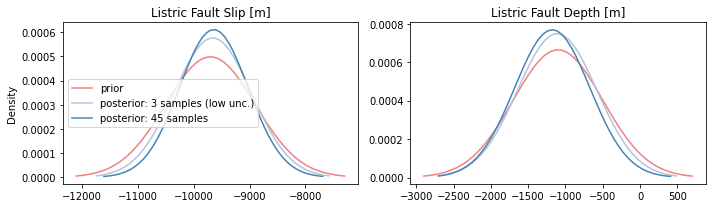

In [53]:
fig, ax = plt.subplots(1,2, figsize= (10,3))

#for prior
x = np.linspace(PrMeanSlip - 3 * PrStdSlip, PrMeanSlip + 3 * PrStdSlip)
y = 1 / (PrStdSlip * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - PrMeanSlip) / PrStdSlip) ** 2)
x2 = np.linspace(PrMeanZ- 3 * PrStdZ, PrMeanZ + 3 * PrStdZ)
y2 = 1 / (PrStdZ * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x2 - PrMeanZ) / PrStdZ) ** 2)

#for posterior
x3 = np.linspace(acc_params3_lowunc[...,1].mean() - 3 * acc_params3_lowunc[...,1].std(), 
                 acc_params3_lowunc[...,1].mean() + 3 * acc_params3_lowunc[...,1].std())
y3 = 1 / (acc_params3_lowunc[...,1].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x3 - acc_params3_lowunc[...,1].mean()) / acc_params3_lowunc[...,1].std()) ** 2)
x4 = np.linspace(acc_params3_lowunc[...,2].mean()- 3 * acc_params3_lowunc[...,2].std(), 
                 acc_params3_lowunc[...,2].mean() + 3 * acc_params3_lowunc[...,2].std())
y4 = 1 / (acc_params3_lowunc[...,2].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x4 - acc_params3_lowunc[...,2].mean()) / acc_params3_lowunc[...,2].std()) ** 2)

x5 = np.linspace(acc_params45[...,1].mean() - 3 * acc_params45[...,1].std(), 
                 acc_params45[...,1].mean() + 3 * acc_params45[...,1].std())
y5 = 1 / (acc_params45[...,1].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x3 - acc_params45[...,1].mean()) / acc_params45[...,1].std()) ** 2)
x6 = np.linspace(acc_params45[...,2].mean()- 3 * acc_params45[...,2].std(), 
                 acc_params45[...,2].mean() + 3 * acc_params45[...,2].std())
y6 = 1 / (acc_params45[...,2].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x4 - acc_params45[...,2].mean()) / acc_params45[...,2].std()) ** 2)

#x7 = np.linspace(acc_params3_highunc[...,1].mean() - 3 * acc_params3_highunc[...,1].std(), 
#                 acc_params3_highunc[...,1].mean() + 3 * acc_params3_highunc[...,1].std())
#y7 = 1 / (acc_params3_highunc[...,1].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x3 - acc_params3_highunc[...,1].mean()) / acc_params3_highunc[...,1].std()) ** 2)
#x8 = np.linspace(acc_params3_highunc[...,2].mean()- 3 * acc_params3_highunc[...,2].std(), 
#                 acc_params3_highunc[...,2].mean() + 3 * acc_params3_highunc[...,2].std())
#y8 = 1 / (acc_params3_highunc[...,2].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x4 - acc_params3_highunc[...,2].mean()) / acc_params3_highunc[...,2].std()) ** 2)

ax[0].plot(x,y, color = 'lightcoral', label = 'prior')
#ax[0].plot(x7,y7, color = 'lightslategrey', label = 'posterior: 3 samples (high unc.)')
ax[0].plot(x3,y3, color = 'lightsteelblue', label = 'posterior: 3 samples (low unc.)')
ax[0].plot(x5,y5, color = 'steelblue', label = 'posterior: 45 samples')

ax[0].legend()
ax[0].set_title('Listric Fault Slip [m]')
ax[0].set_ylabel('Density')

ax[1].plot(x2,y2, color = 'lightcoral')
ax[1].plot(x4,y4, color = 'lightsteelblue')
ax[1].plot(x6,y6, color = 'steelblue')

ax[1].set_title('Listric Fault Depth [m]')


plt.tight_layout()
#plt.savefig(f'../figures/{model}_postvsposterior.svg')
plt.show()

### prior versus posterior exhumation

In [64]:
acc_exh3_lowunc = extractfiles(f'{output_folder}/{model}_exh_3samples','accepted')
rej_exh3_lowunc = extractfiles(f'{output_folder}/{model}_exh_3samples','rejected')

In [67]:
#remove 9999 outliers caused by IndexError- not real data
def remove_outliers(exh_array):
    sample1r, sample2r, sample3r = [],[],[]
    for i in range(len(exh_array)):
        s_1 = exh_array[i][0]
        s_2 = exh_array[i][1]
        s_3 = exh_array[i][2]
        sample1r.append(s_1)
        sample2r.append(s_2)
        sample3r.append(s_3)
    sample1r = [x for x in sample1r if x <= 9000]
    sample2r = [x for x in sample2r if x <= 9000]
    sample3r = [x for x in sample3r if x <= 9000]
    return sample1r, sample2r, sample3r

In [68]:
sample1, sample2, sample3 = remove_outliers(acc_exh3_lowunc)
sample1r, sample2r, sample3r = remove_outliers(rej_exh3_lowunc)

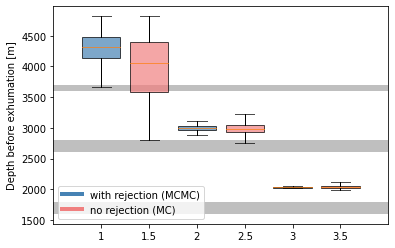

In [69]:
fig, ax = plt.subplots()
width = 0.4
positions = [1,1.5,2,2.5,3,3.5]

box1a = ax.boxplot(sample1, positions = [positions[0]], widths = width, patch_artist = True, boxprops=dict(facecolor='steelblue'), showfliers = False)
box1r = ax.boxplot(sample1r, positions = [positions[1]], widths = width, patch_artist = True, boxprops=dict(facecolor='lightcoral'), showfliers = False)
box2a = ax.boxplot(sample2, positions = [positions[2]], widths = width, patch_artist = True, boxprops=dict(facecolor='steelblue'), showfliers = False)
box2r = ax.boxplot(sample2r, positions = [positions[3]], widths = width, patch_artist = True, boxprops=dict(facecolor='lightcoral'), showfliers = False)
box3a = ax.boxplot(sample3, positions = [positions[4]], widths = width, patch_artist = True, boxprops=dict(facecolor='steelblue'), showfliers = False)
box3r = ax.boxplot(sample3r, positions = [positions[5]], widths = width, patch_artist = True, boxprops=dict(facecolor='lightcoral'), showfliers = False)

ax.axhspan(3600, 3700, facecolor='grey', alpha=0.5)
ax.axhspan(2600, 2800, facecolor='grey', alpha=0.5)
ax.axhspan(1600, 1800, facecolor='grey', alpha=0.5)

for box in [box1a, box2a, box3a, box1r, box2r, box3r]:
    for element in ['boxes','means', 'medians', 'caps']:
        plt.setp(box[element], alpha=0.7)
legend_elements = [
    plt.Line2D([0], [0], color='steelblue', lw=4, label='with rejection (MCMC)'),
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='no rejection (MC)')
]
ax.legend(handles=legend_elements, loc='lower left')

ax.set_ylabel('Depth before exhumation [m]')
plt.savefig(f'../figures/{model}_boxplot.svg')
plt.show()